# Pathfinding Exploration

- DFS
- BFS
- IDDFS (removed completely)
- A-star

In [130]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from statistics import stdev, mean

from utils.finders import bfs, dfs, dfs_heuristic, greedy_bfs, a_star, jps
from utils.search import Search
from utils.plots import plot_grid, plot_path, bar_chart_performance

In [131]:
colormap = {
    "bfs": "blue",
    "greedy_bfs": "green",
    "dfs": "orange",
    "dfs_heur": "red",
    "a_star": "purple"
}

## A simple example of N = 1

Also showing the different types of grids that can be used.

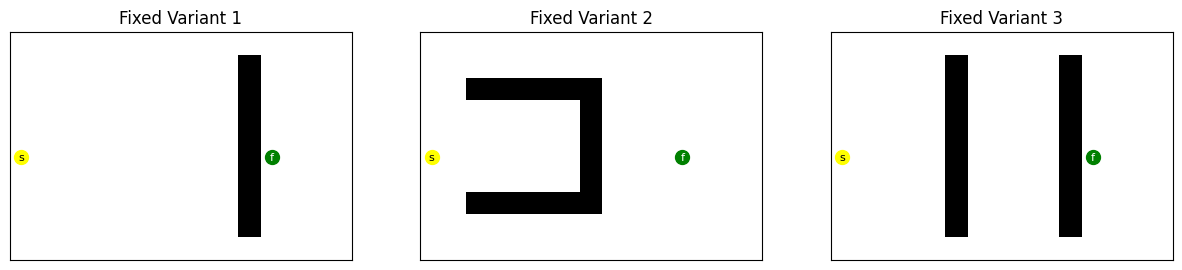

In [132]:
search = Search(rows=10, cols=15)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

for variant in [0,1,2]:
    search.generate_grid(grid_type="fixed", variant=variant)
    axes[variant].imshow(search.grid.grid, cmap="gray", interpolation="none")
    axes[variant].set_xticks([])
    axes[variant].set_yticks([])

    axes[variant].scatter(x=search.p_start[1], y=search.p_start[0], s=100, c="yellow", marker="o")
    axes[variant].text(
        x=search.p_start[1],
        y=search.p_start[0],
        s="s",
        c="black",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=8,
    )
    axes[variant].scatter(x=search.p_end[1], y=search.p_end[0], s=100, c="green", marker="o")
    axes[variant].text(
        x=search.p_end[1],
        y=search.p_end[0],
        s="f",
        c="white",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=8,
    )
    axes[variant].set_title(f"Fixed Variant {variant + 1}")
plt.show()

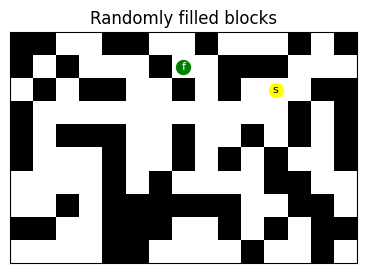

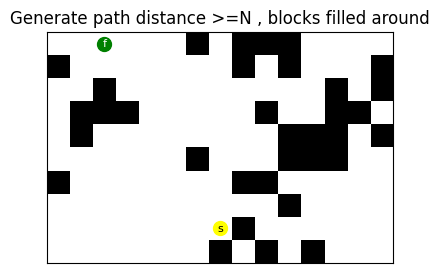

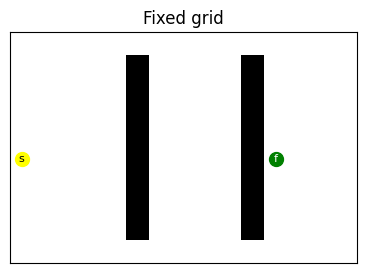

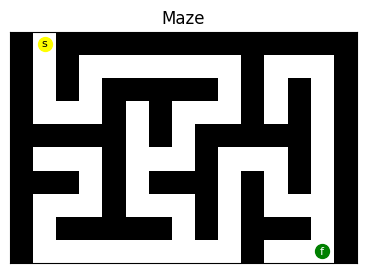

In [53]:
percent_blockage = 0.4

search = Search(rows=10, cols=15)


search.generate_grid(grid_type="random", percent_blocked=percent_blockage)
plot_grid(search.p_start, search.p_end, search.grid.grid)
plt.title("Randomly filled blocks")
plt.show()

search.generate_grid(grid_type="random-1", percent_blocked=percent_blockage)
plot_grid(search.p_start, search.p_end, search.grid.grid)
plt.title("Generate path distance >=N , blocks filled around")
plt.show()

search.generate_grid(grid_type="fixed", variant=2)
plot_grid(search.p_start, search.p_end, search.grid.grid)
plt.title("Fixed grid")
plt.show()

search.generate_grid(grid_type="maze")
plot_grid(search.p_start, search.p_end, search.grid.grid)
plt.title("Maze")
plt.show()

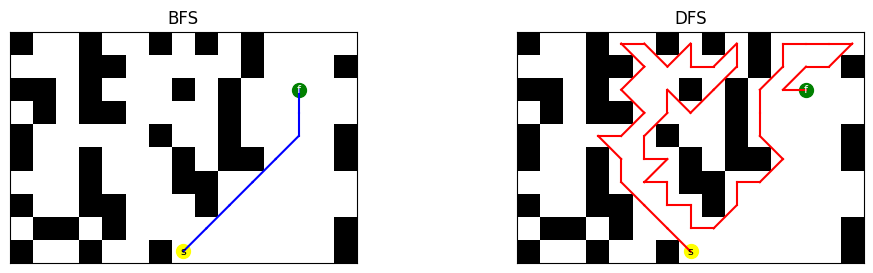

BFS:
Time: 0.0002751350402832031 (s)
# Iteractions: 69
Path length: 7

DFS:
Time: 0.0002391338348388672 (s)
# Iteractions: 81
Path length: 46


In [133]:
percent_blockage = 0.4
search = Search(rows=10, cols=15)

search.generate_grid(grid_type="random-1", percent_blocked=percent_blockage, allow_diagonal=True)

bfs_path, bfs_complexity = search.search(bfs)
dfs_path, dfs_complexity = search.search(dfs)

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,3))

plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], dfs_path, c='red',label='DFS')

plt.show()

print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("DFS:")
print("Time:", dfs_complexity["time"], "(s)")
print("# Iteractions:", dfs_complexity["iterations"])
print("Path length:", dfs_complexity["length"])

### Let's see this interactively

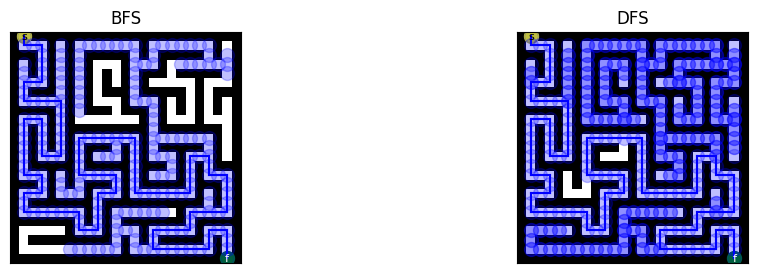

In [135]:
search = Search(rows=25, cols=25)
search.generate_grid(grid_type="maze")

bfs_generator = search.search_generator(bfs)
dfs_generator = search.search_generator(dfs)

generators = [bfs_generator, dfs_generator]

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("DFS")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

## Let's do this many times and compare.

Important to note that as the `percent_blockage` gets to a certain point, there tends to become less and less available paths (and neighbors), so we see some convergence between methods. I'll stop it by a certain point, as we're guaranteeing an existing path, so going beyond a certain `percent_blockage` becomes redundant.

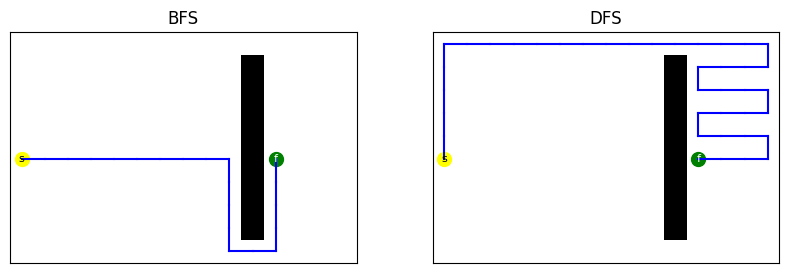

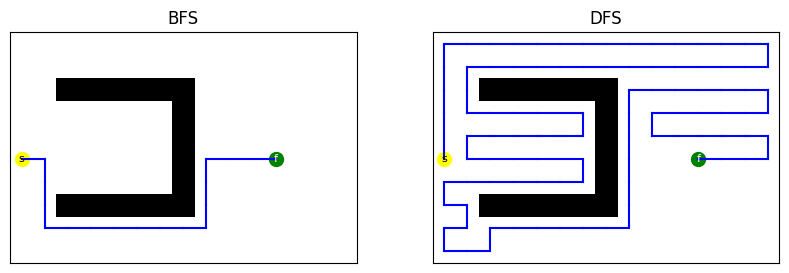

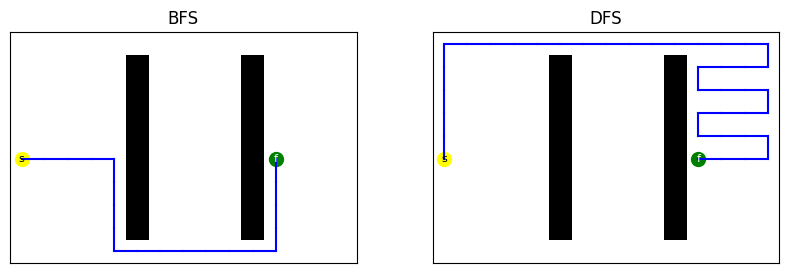

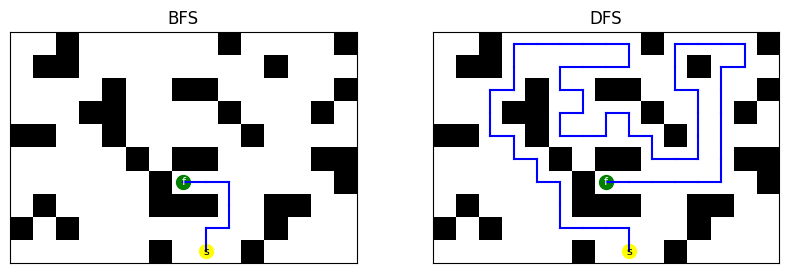

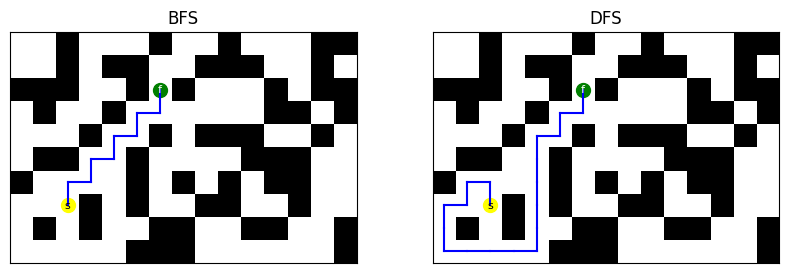

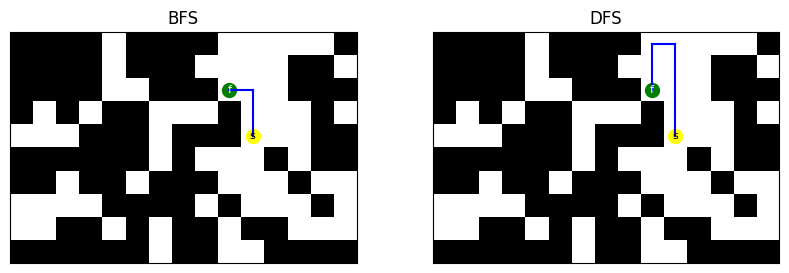

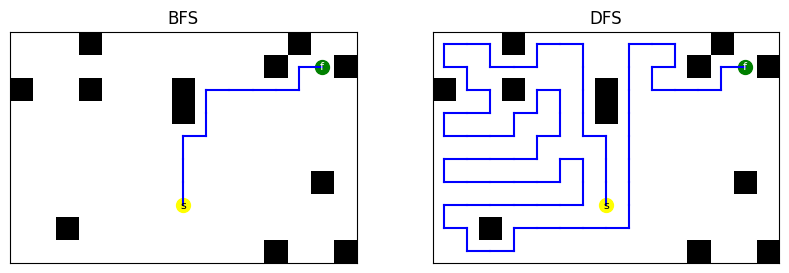

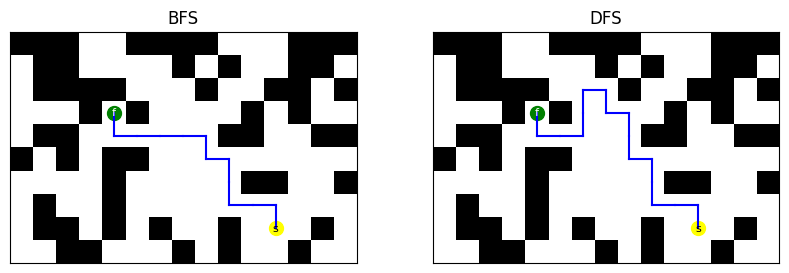

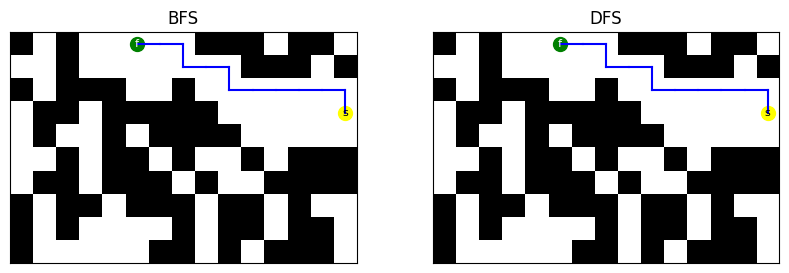

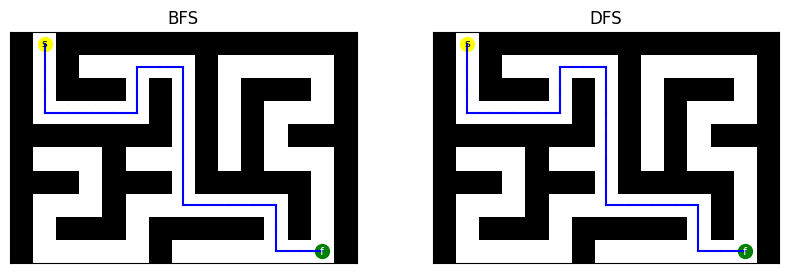

In [136]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

search = Search(rows=10, cols=15)

to_search = [
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "dfs",
        "label": "DFS",
        "fct": dfs,
    },
]

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
    }

    search.generate_grid(grid_type="fixed", variant=variant)

    _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
    plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

    for i, searcher in enumerate(to_search):
        fct = searcher["fct"]
        name = searcher["name"]
        label = searcher["label"]
        path, complexity = search.search(searcher["fct"])

        data[name] = {"time": {}, "iterations": {}, "length": {}}

        data[name]["time"]["avg"] = complexity["time"]
        data[name]["iterations"]["avg"] = complexity["iterations"]
        data[name]["length"]["avg"] = complexity["length"]

        data[name]["time"]["std"] = 0
        data[name]["iterations"]["std"] = 0
        data[name]["length"]["std"] = 0

        plot_path(axes[i], path, c='blue',label=label)

    plt.show()

    datas.append(data)

for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": grid_type,
        }

        accumulator = {}
        for i in range(n):
            search.generate_grid(grid_type=grid_type, percent_blocked=percent)

            if i == n - 1:
                _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
                plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

            for j, searcher in enumerate(to_search):
                fct = searcher["fct"]
                name = searcher["name"]
                label = searcher["label"]
                path, complexity = search.search(searcher["fct"])

                if name not in accumulator:
                    accumulator[name] = {"time": [], "iterations": [], "length": []}
                
                accumulator[name]["time"].append(complexity["time"])
                accumulator[name]["iterations"].append(complexity["iterations"])
                accumulator[name]["length"].append(complexity["length"])

                if i == n - 1:
                    plot_path(axes[j], path, c='blue',label=label)
        plt.show()

        for name, keys in accumulator.items():
            data[name] = {}
            for key, values in keys.items():
                data[name][key] = {"avg": mean(values), "std": stdev(values)}
        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
}

accumulator = {}
for i in range(n):
    search.generate_grid(grid_type="maze")

    if i == n - 1:
        _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
        plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

    for j, searcher in enumerate(to_search):
        fct = searcher["fct"]
        name = searcher["name"]
        label = searcher["label"]
        path, complexity = search.search(searcher["fct"])

        if complexity["time"] is None: continue

        if name not in accumulator:
            accumulator[name] = {"time": [], "iterations": [], "length": []}
        
        accumulator[name]["time"].append(complexity["time"])
        accumulator[name]["iterations"].append(complexity["iterations"])
        accumulator[name]["length"].append(complexity["length"])

        if i == n - 1:
            plot_path(axes[j], path, c='blue',label=label)
plt.show()

for name, keys in accumulator.items():
    data[name] = {}
    for key, values in keys.items():
        data[name][key] = {"avg": mean(values), "std": stdev(values)}
datas.append(data)


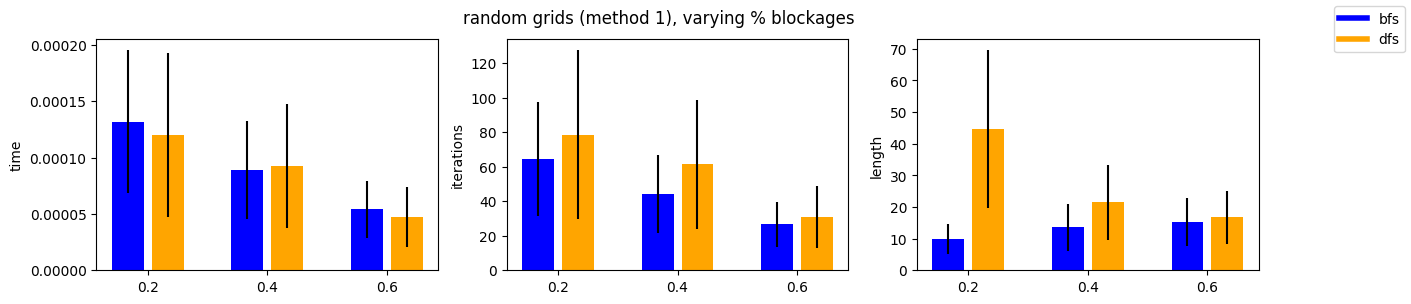

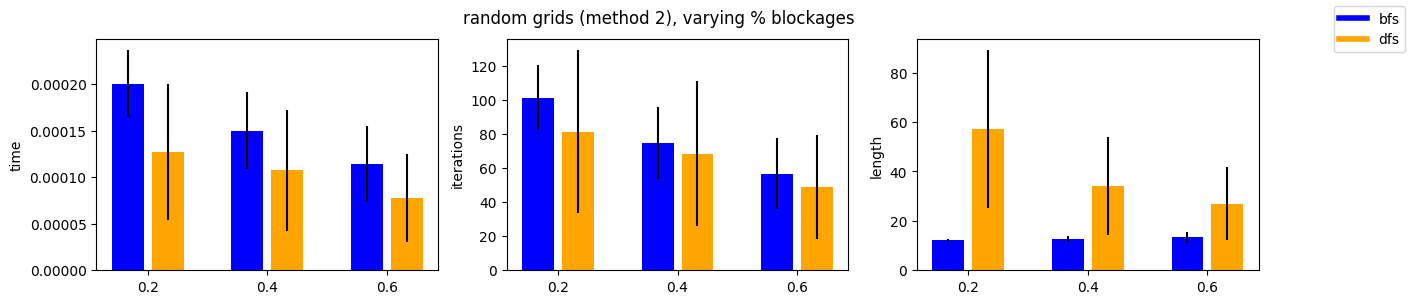

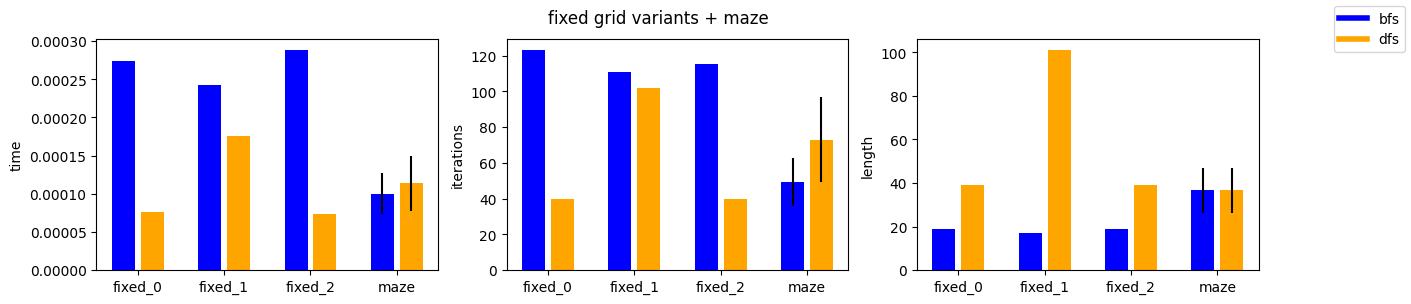

In [137]:
items_plot = list(map(lambda x : x["name"], to_search))

partition = list(filter(lambda x : x["type"] == "random", datas))
fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="percent", figsize=(15,3))
fig.suptitle("random grids (method 1), varying % blockages")
plt.show()

partition = list(filter(lambda x : x["type"] == "random-1", datas))
fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="percent", figsize=(15,3))
fig.suptitle("random grids (method 2), varying % blockages")
plt.show()

partition = list(filter(lambda x : x["type"].startswith("fixed") or x["type"] == "maze", datas))
fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="type", figsize=(15,3))
fig.suptitle("fixed grid variants + maze")
plt.show()

# Adding heuristics to search

Right now selecting a neighbor has equivalent "cost". We know where the starting + end locations are located, so can we use this information?

Rather than BFS / DFS randomly traversing the space, let's intro some heuristics.

Doing this will also introduce a new Data Structure `Priority Queue`. Rather than simply using a queue, we can sort it based on some priority given a heuristic.

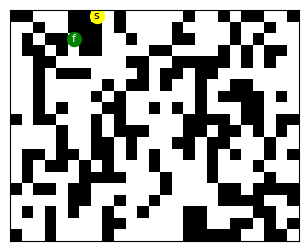

In [138]:
percent_blockage = 0.4
search = Search(rows=20, cols=25)
search.generate_grid(grid_type="random", percent_blocked=percent_blockage, allow_diagonal=True)

plot_grid(search.p_start, search.p_end, search.grid.grid)
plt.show()

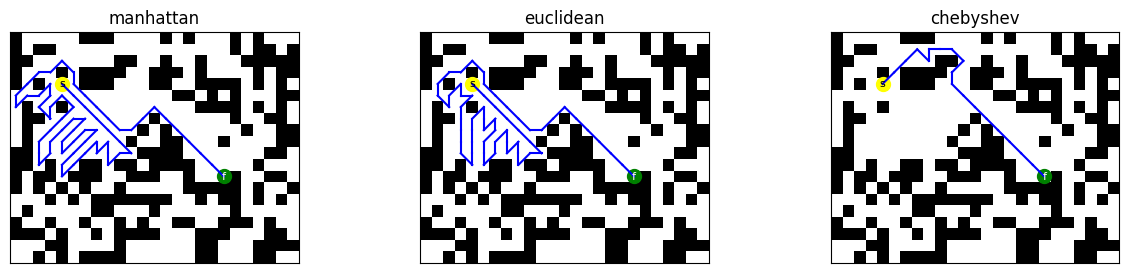

In [139]:
percent_blockage = 0.4
search = Search(rows=20, cols=25)
search.generate_grid(grid_type="random-1", percent_blocked=percent_blockage, allow_diagonal=True)


paths = []
complexities = []
ds = ["manhattan", "euclidean", "chebyshev"]
for i,d in enumerate(ds):
    p, c = search.search(dfs_heuristic, method=d)
    paths.append(p)
    complexities.append(c)


_, axes = plt.subplots(ncols=len(paths), nrows=1, figsize=(len(paths) * 5,3))

plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

for i,(p,c) in enumerate(zip(paths,complexities)):
    plot_path(axes[i], p, color="blue", label=ds[i])

plt.show()

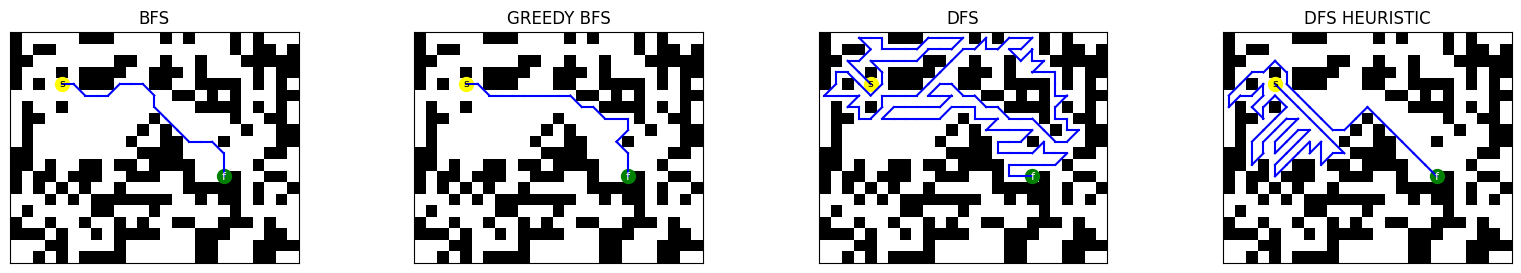

BFS
Time: 0.0005738735198974609 (s)
# Iteractions: 171
Path length: 17

GREEDY BFS
Time: 0.00017595291137695312 (s)
# Iteractions: 20
Path length: 19

DFS
Time: 0.0004532337188720703 (s)
# Iteractions: 160
Path length: 127

DFS HEURISTIC
Time: 0.0007770061492919922 (s)
# Iteractions: 81
Path length: 64



In [140]:
searches = [
    {"name": "BFS", "fct": bfs},
    {"name": "GREEDY BFS", "fct": greedy_bfs},
    {"name": "DFS", "fct": dfs},
    {"name": "DFS HEURISTIC", "fct": dfs_heuristic},
]

_, axes = plt.subplots(ncols=len(searches), nrows=1, figsize=(len(searches) * 5, 3))

plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

complexities = []

for i, to_search in enumerate(searches):
    p, c = search.search(to_search["fct"])
    complexities.append(c)

    plot_path(axes[i], p, c='blue',label=to_search["name"])

plt.show()

for i, to_search in enumerate(searches):
    print(to_search["name"])
    print("Time:", complexities[i]["time"], "(s)")
    print("# Iteractions:", complexities[i]["iterations"])
    print("Path length:", complexities[i]["length"])
    print()

### Again, let's see this interactively to how the heuristic behaves

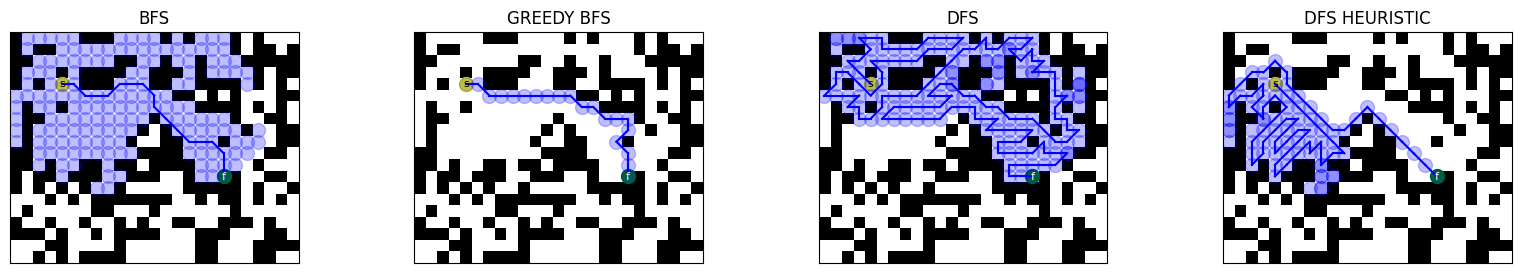

In [141]:
bfs_generator = search.search_generator(bfs)
greedy_bfs_generator = search.search_generator(greedy_bfs)
dfs_generator = search.search_generator(dfs)
dfs_heur_generator = search.search_generator(dfs_heuristic)

generators = [bfs_generator, greedy_bfs_generator, dfs_generator, dfs_heur_generator]

_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("DFS")
    axes[3].set_title("DFS HEURISTIC")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

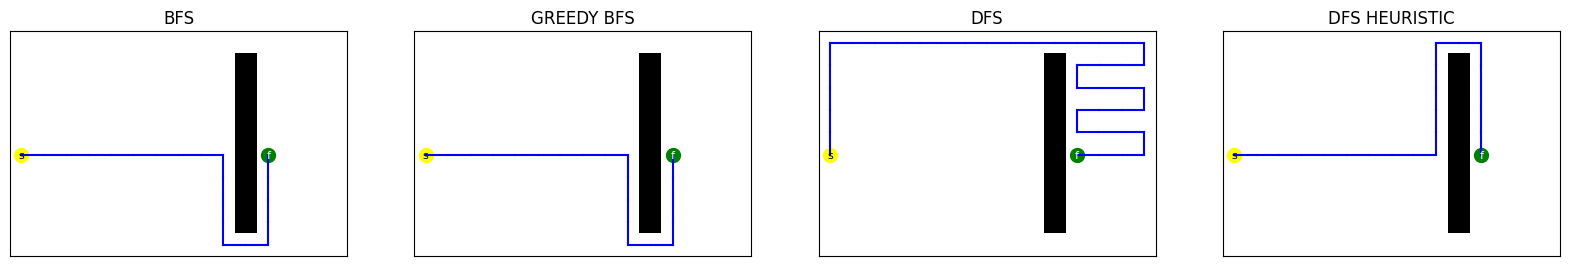

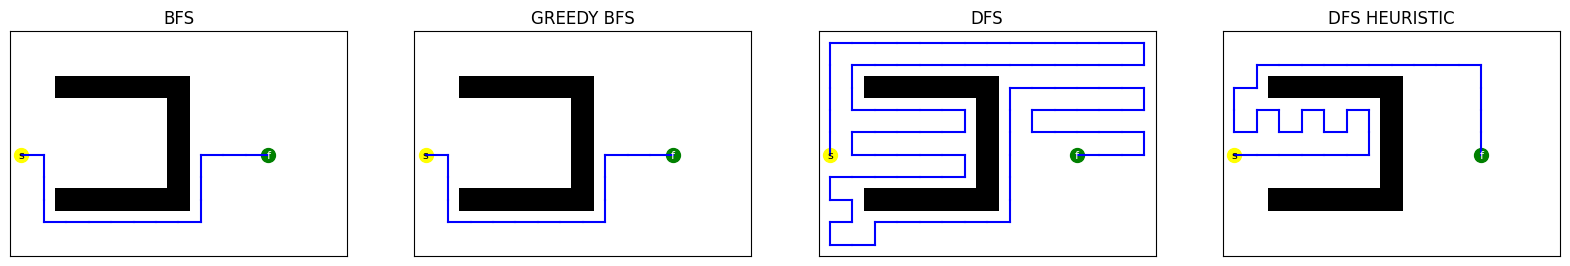

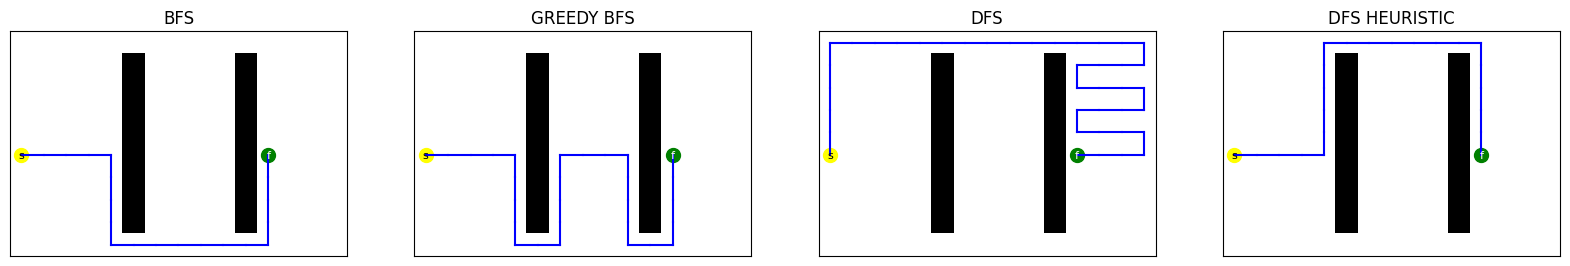

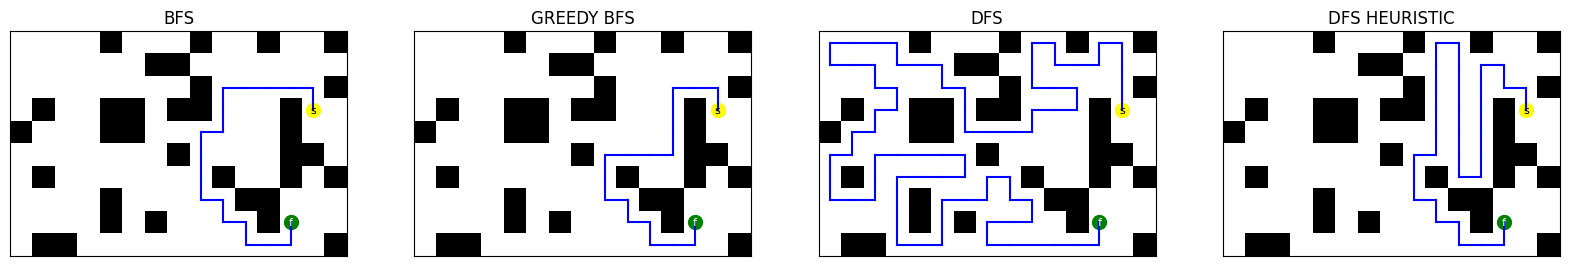

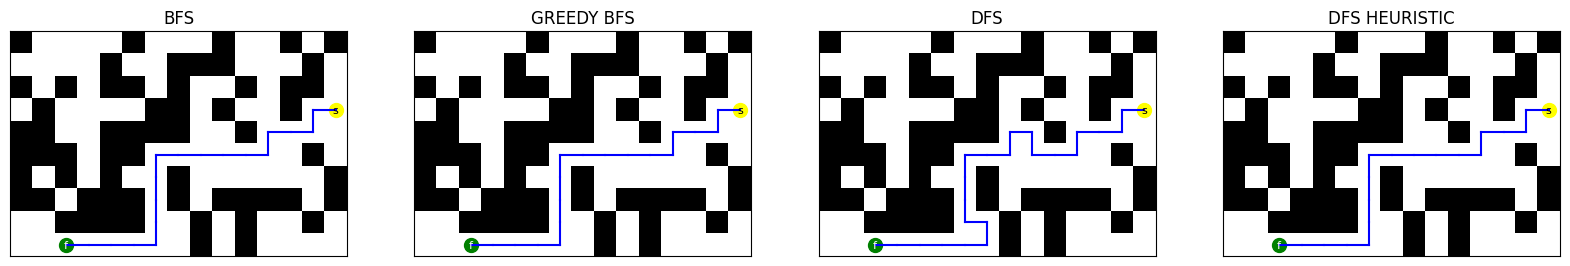

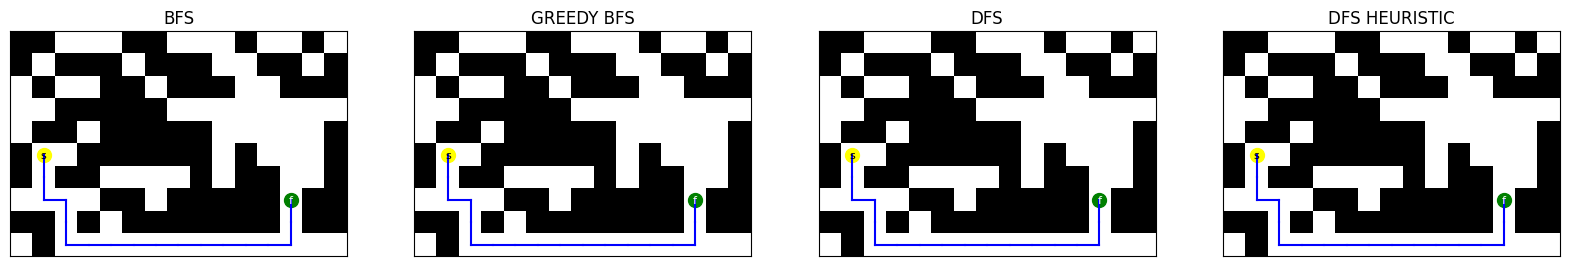

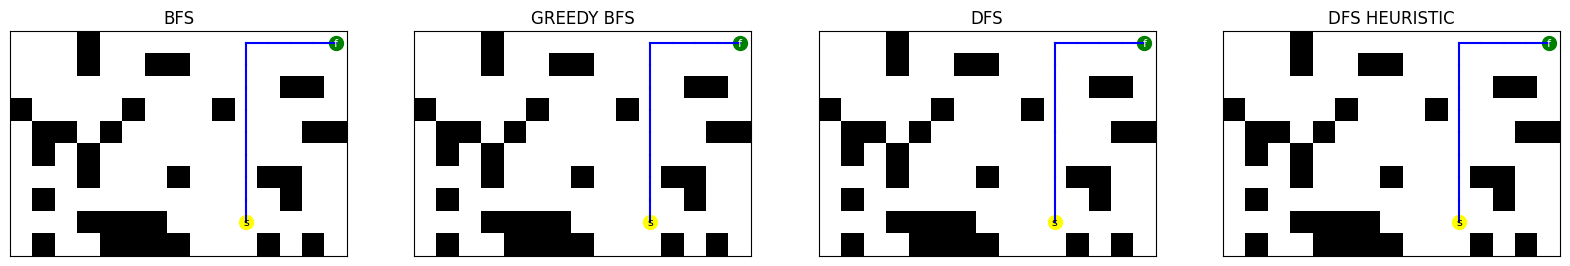

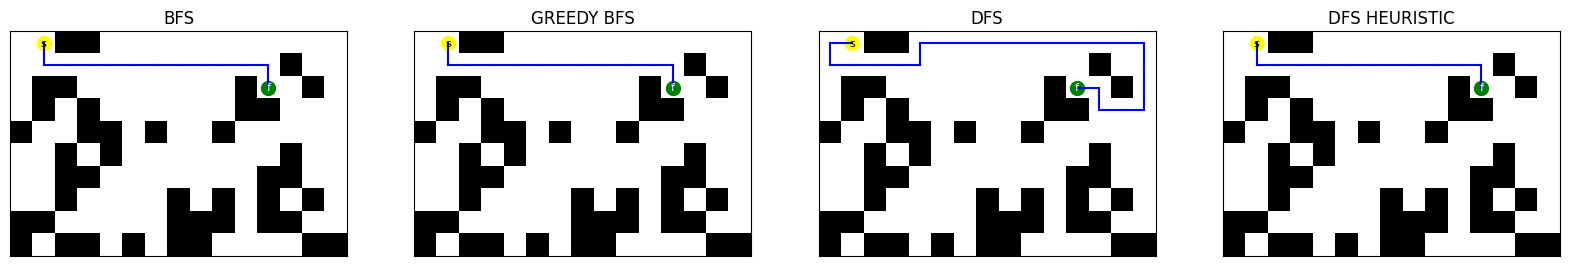

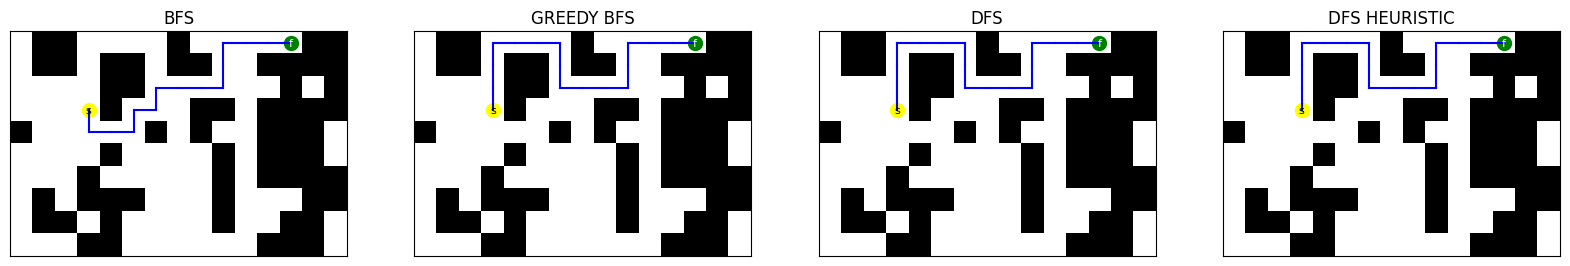

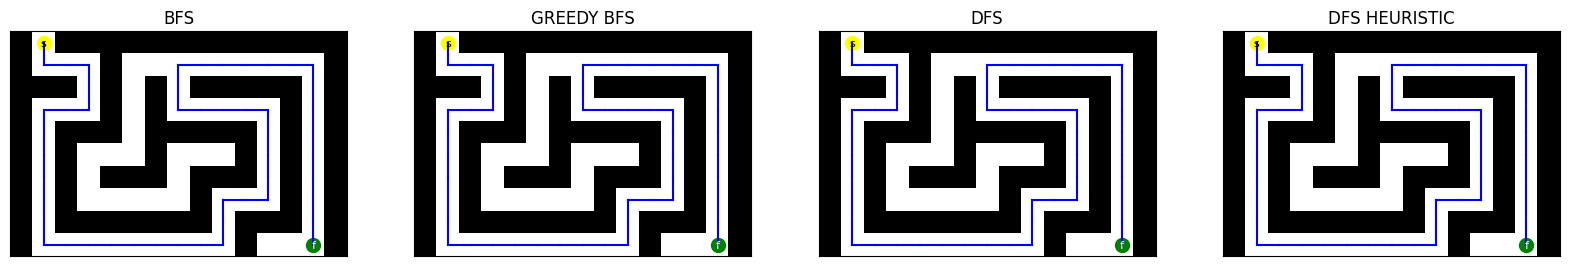

In [144]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

search = Search(rows=10, cols=15)

to_search = [
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "greedy_bfs",
        "label": "GREEDY BFS",
        "fct": greedy_bfs,
    },
    {
        "name": "dfs",
        "label": "DFS",
        "fct": dfs,
    },
    {
        "name": "dfs_heur",
        "label": "DFS HEURISTIC",
        "fct": dfs_heuristic,
    }
]

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
    }

    search.generate_grid(grid_type="fixed", variant=variant)

    _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
    plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

    for i, searcher in enumerate(to_search):
        fct = searcher["fct"]
        name = searcher["name"]
        label = searcher["label"]
        path, complexity = search.search(searcher["fct"])

        data[name] = {"time": {}, "iterations": {}, "length": {}}

        data[name]["time"]["avg"] = complexity["time"]
        data[name]["iterations"]["avg"] = complexity["iterations"]
        data[name]["length"]["avg"] = complexity["length"]

        data[name]["time"]["std"] = 0
        data[name]["iterations"]["std"] = 0
        data[name]["length"]["std"] = 0

        plot_path(axes[i], path, c='blue',label=label)

    plt.show()

    datas.append(data)

for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": grid_type,
        }

        accumulator = {}
        for i in range(n):
            search.generate_grid(grid_type=grid_type, percent_blocked=percent)

            if i == n - 1:
                _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
                plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

            for j, searcher in enumerate(to_search):
                fct = searcher["fct"]
                name = searcher["name"]
                label = searcher["label"]
                path, complexity = search.search(searcher["fct"])

                if name not in accumulator:
                    accumulator[name] = {"time": [], "iterations": [], "length": []}
                
                accumulator[name]["time"].append(complexity["time"])
                accumulator[name]["iterations"].append(complexity["iterations"])
                accumulator[name]["length"].append(complexity["length"])

                if i == n - 1:
                    plot_path(axes[j], path, c='blue',label=label)
        plt.show()

        for name, keys in accumulator.items():
            data[name] = {}
            for key, values in keys.items():
                data[name][key] = {"avg": mean(values), "std": stdev(values)}
        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
}

accumulator = {}
for i in range(n):
    search.generate_grid(grid_type="maze")

    if i == n - 1:
        _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
        plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

    for j, searcher in enumerate(to_search):
        fct = searcher["fct"]
        name = searcher["name"]
        label = searcher["label"]
        path, complexity = search.search(searcher["fct"])

        if complexity["time"] is None: continue

        if name not in accumulator:
            accumulator[name] = {"time": [], "iterations": [], "length": []}
        
        accumulator[name]["time"].append(complexity["time"])
        accumulator[name]["iterations"].append(complexity["iterations"])
        accumulator[name]["length"].append(complexity["length"])

        if i == n - 1:
            plot_path(axes[j], path, c='blue',label=label)
plt.show()

for name, keys in accumulator.items():
    data[name] = {}
    for key, values in keys.items():
        data[name][key] = {"avg": mean(values), "std": stdev(values)}
datas.append(data)


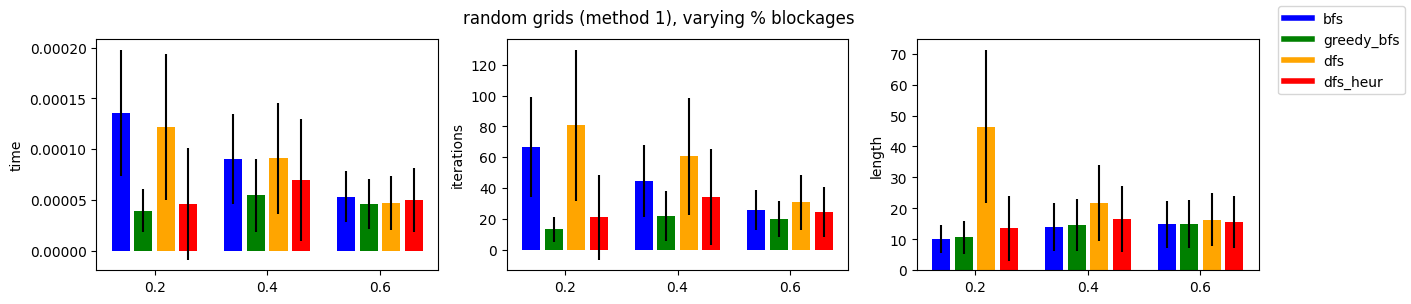

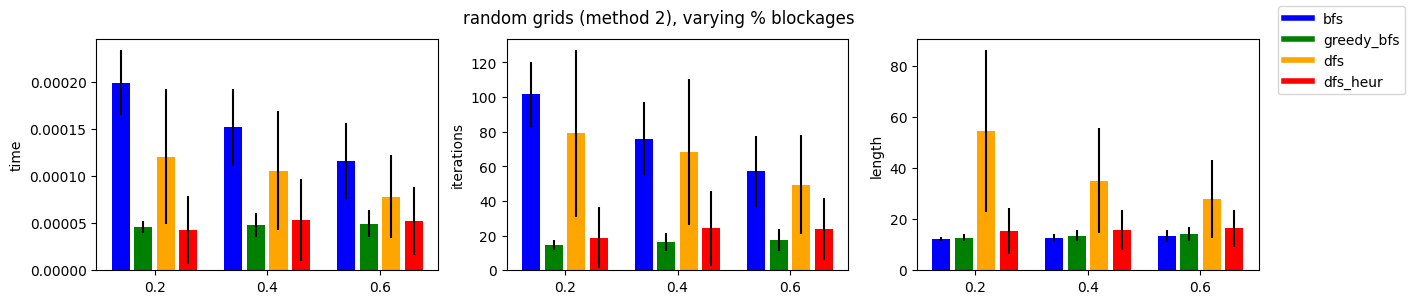

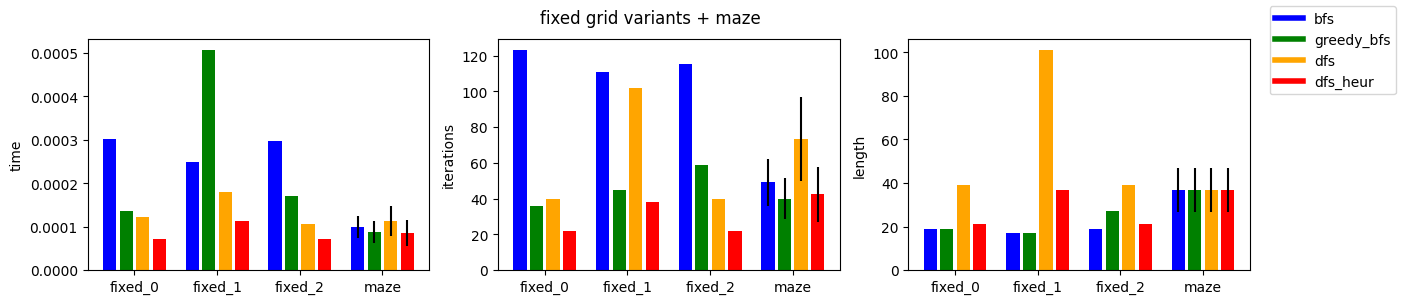

In [145]:
items_plot = list(map(lambda x : x["name"], to_search))

partition = list(filter(lambda x : x["type"] == "random", datas))
fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="percent", figsize=(15,3))
fig.suptitle("random grids (method 1), varying % blockages")
plt.show()

partition = list(filter(lambda x : x["type"] == "random-1", datas))
fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="percent", figsize=(15,3))
fig.suptitle("random grids (method 2), varying % blockages")
plt.show()

partition = list(filter(lambda x : x["type"].startswith("fixed") or x["type"] == "maze", datas))
fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="type", figsize=(15,3))
fig.suptitle("fixed grid variants + maze")
plt.show()

## Let's add another algorithm, but introduce costs.

A* algorithm is used here. The heuristic gave us some speed ups, but it isn't guaranteed to find the optimal path. We'll introduce costs here.

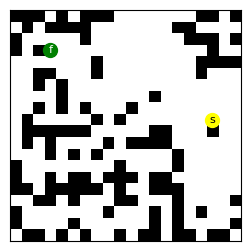

In [146]:
percent_blockage = 0.4

search = Search(rows=20, cols=20)
search.generate_grid(grid_type="random-1", percent_blocked=percent_blockage, allow_diagonal=True)

plot_grid(search.p_start, search.p_end, search.grid.grid)
plt.show()

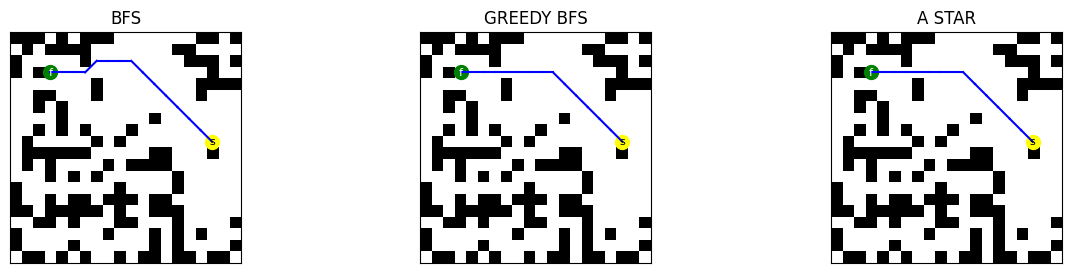

BFS
Time: 0.0006949901580810547 (s)
# Iteractions: 199
Path length: 14

GREEDY BFS
Time: 9.775161743164062e-05 (s)
# Iteractions: 15
Path length: 14

A STAR
Time: 0.00010204315185546875 (s)
# Iteractions: 15
Path length: 14



In [147]:
searches = [
    {"name": "BFS", "fct": bfs},
    {"name": "GREEDY BFS", "fct": greedy_bfs},
    {"name": "A STAR", "fct": a_star},
]

_, axes = plt.subplots(ncols=len(searches), nrows=1, figsize=(len(searches) * 5, 3))

plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

complexities = []

for i, to_search in enumerate(searches):
    p, c = search.search(to_search["fct"], method="manhattan")
    complexities.append(c)

    plot_path(axes[i], p, c='blue',label=to_search["name"])

plt.show()

for i, to_search in enumerate(searches):
    print(to_search["name"])
    print("Time:", complexities[i]["time"], "(s)")
    print("# Iteractions:", complexities[i]["iterations"])
    print("Path length:", complexities[i]["length"])
    print()

### Let's see it in action

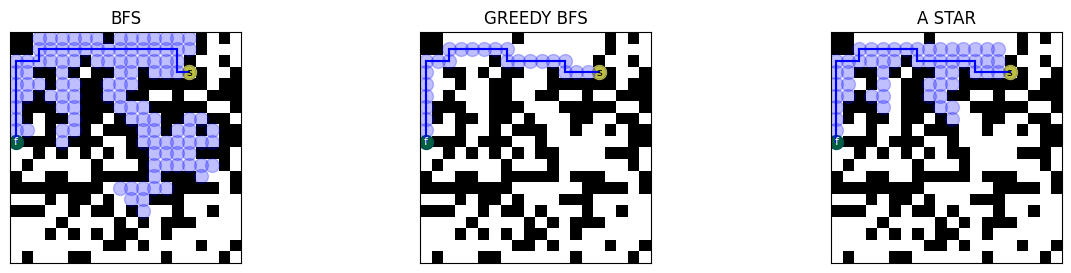

In [149]:
percent_blockage = 0.4

search = Search(rows=20, cols=20)
search.generate_grid(grid_type="random-1", percent_blocked=percent_blockage)

bfs_generator = search.search_generator(bfs)
greedy_bfs_generator = search.search_generator(greedy_bfs)
astar_generator = search.search_generator(a_star)

generators = [bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

### And with allowing for diagonals

In [158]:
percent_blockage = 0.4

search = Search(rows=25, cols=25)
search.generate_grid(grid_type="random-1", percent_blocked=percent_blockage, allow_diagonal=True)

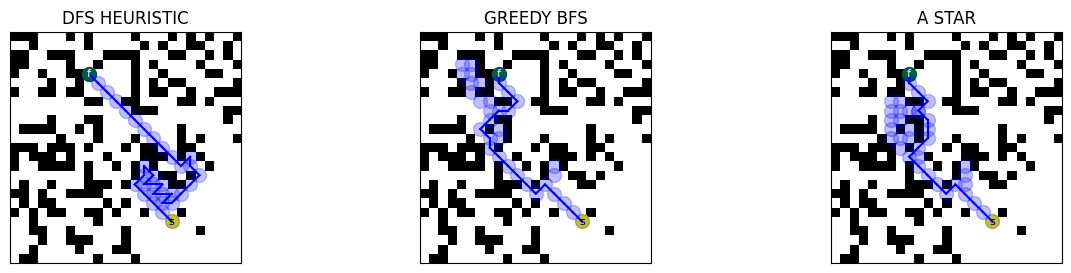

In [159]:
dfs_heur_generator = search.search_generator(dfs_heuristic)
greedy_bfs_generator = search.search_generator(greedy_bfs)
astar_generator = search.search_generator(a_star)

generators = [dfs_heur_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS HEURISTIC")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

### Let's try a different distance heuristic

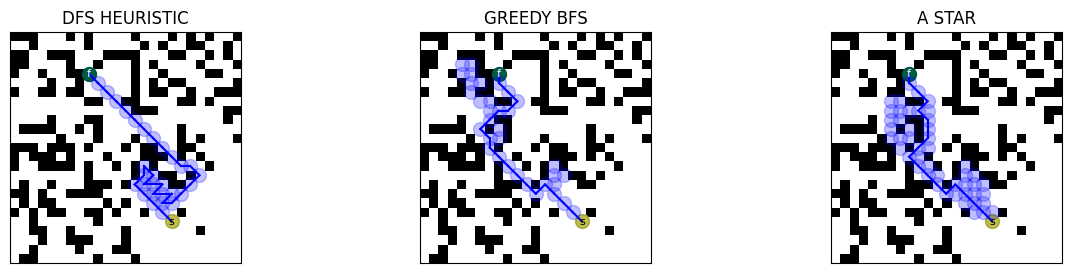

In [160]:
dfs_heur_generator = search.search_generator(dfs_heuristic, method="euclidean")
greedy_bfs_generator = search.search_generator(greedy_bfs, method="euclidean")
astar_generator = search.search_generator(a_star, method="euclidean")

generators = [dfs_heur_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS HEURISTIC")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

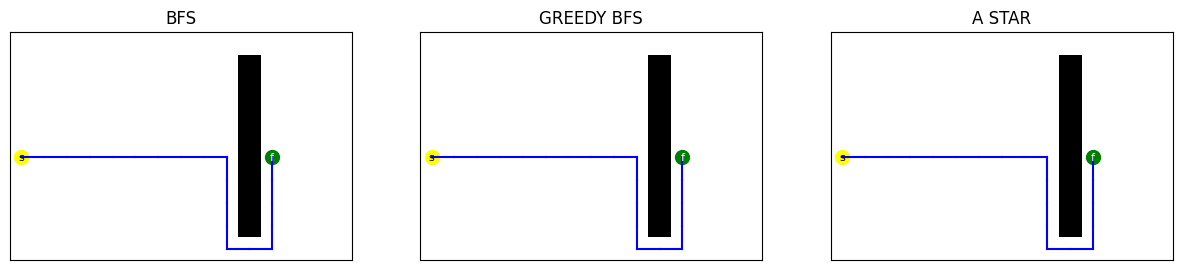

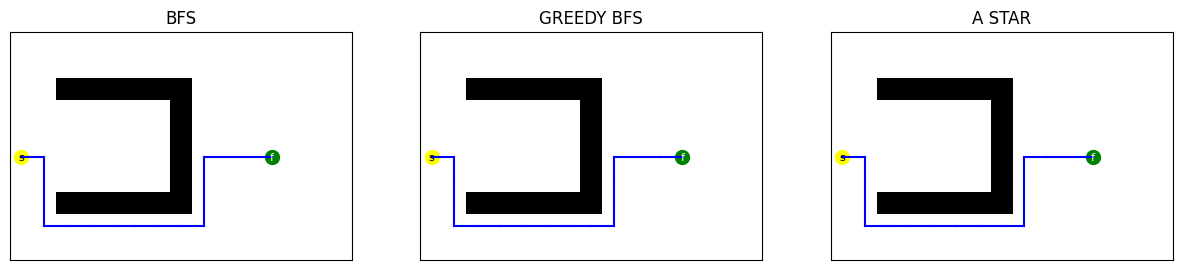

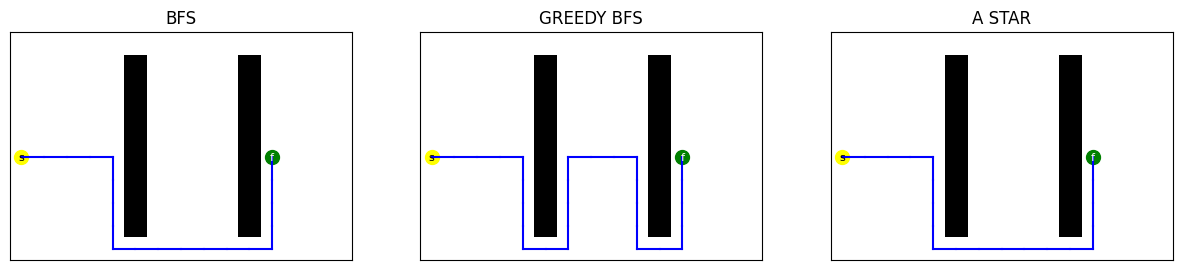

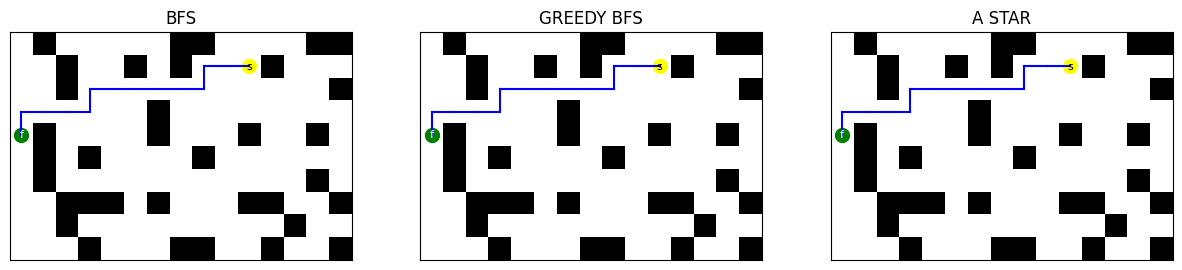

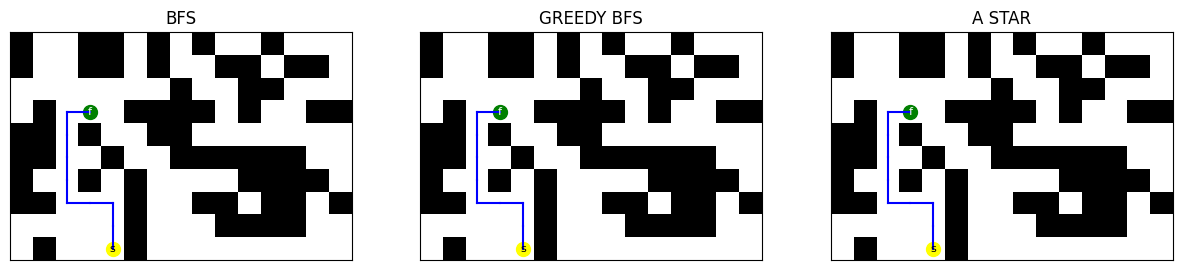

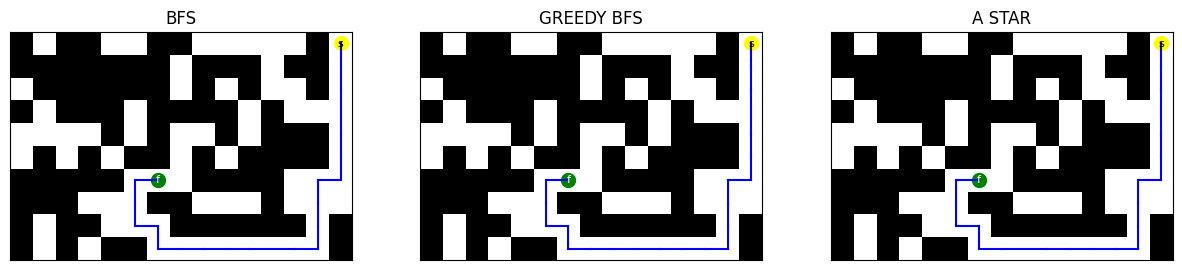

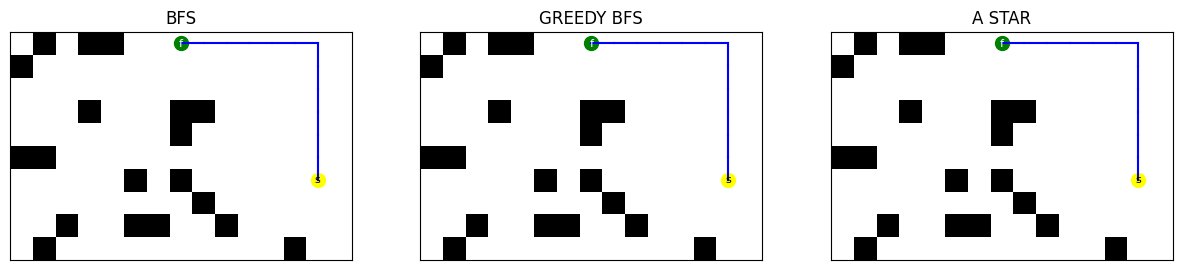

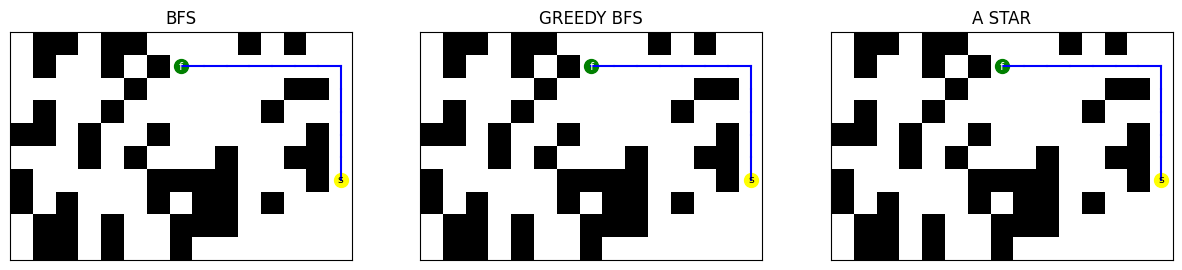

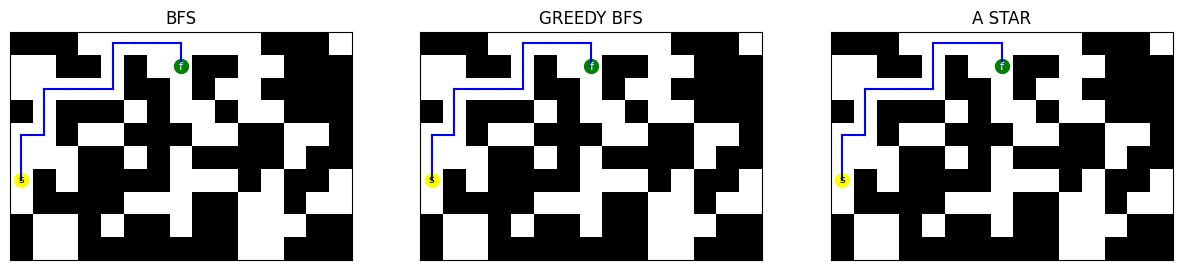

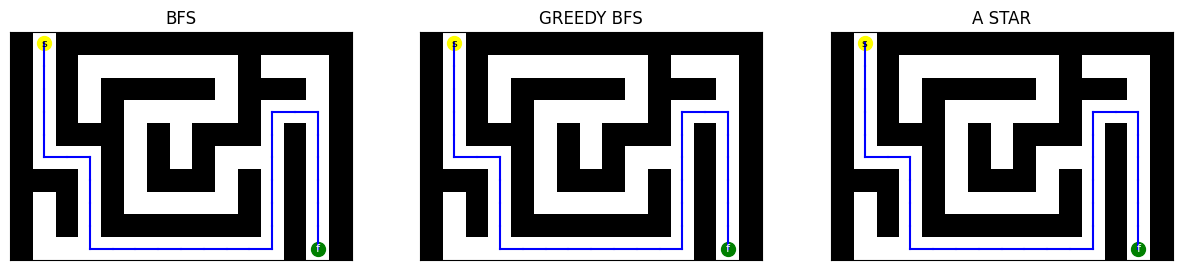

In [161]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

search = Search(rows=10, cols=15)

to_search = [
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "greedy_bfs",
        "label": "GREEDY BFS",
        "fct": greedy_bfs,
    },
    {
        "name": "a_star",
        "label": "A STAR",
        "fct": a_star,
    },
]

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
    }

    search.generate_grid(grid_type="fixed", variant=variant)

    _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
    plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

    for i, searcher in enumerate(to_search):
        fct = searcher["fct"]
        name = searcher["name"]
        label = searcher["label"]
        path, complexity = search.search(searcher["fct"])

        data[name] = {"time": {}, "iterations": {}, "length": {}}

        data[name]["time"]["avg"] = complexity["time"]
        data[name]["iterations"]["avg"] = complexity["iterations"]
        data[name]["length"]["avg"] = complexity["length"]

        data[name]["time"]["std"] = 0
        data[name]["iterations"]["std"] = 0
        data[name]["length"]["std"] = 0

        plot_path(axes[i], path, c='blue',label=label)

    plt.show()

    datas.append(data)

for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": grid_type,
        }

        accumulator = {}
        for i in range(n):
            search.generate_grid(grid_type=grid_type, percent_blocked=percent)

            if i == n - 1:
                _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
                plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

            for j, searcher in enumerate(to_search):
                fct = searcher["fct"]
                name = searcher["name"]
                label = searcher["label"]
                path, complexity = search.search(searcher["fct"])

                if name not in accumulator:
                    accumulator[name] = {"time": [], "iterations": [], "length": []}
                
                accumulator[name]["time"].append(complexity["time"])
                accumulator[name]["iterations"].append(complexity["iterations"])
                accumulator[name]["length"].append(complexity["length"])

                if i == n - 1:
                    plot_path(axes[j], path, c='blue',label=label)
        plt.show()

        for name, keys in accumulator.items():
            data[name] = {}
            for key, values in keys.items():
                data[name][key] = {"avg": mean(values), "std": stdev(values)}
        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
}

accumulator = {}
for i in range(n):
    search.generate_grid(grid_type="maze")

    if i == n - 1:
        _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
        plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

    for j, searcher in enumerate(to_search):
        fct = searcher["fct"]
        name = searcher["name"]
        label = searcher["label"]
        path, complexity = search.search(searcher["fct"])

        if complexity["time"] is None: continue

        if name not in accumulator:
            accumulator[name] = {"time": [], "iterations": [], "length": []}
        
        accumulator[name]["time"].append(complexity["time"])
        accumulator[name]["iterations"].append(complexity["iterations"])
        accumulator[name]["length"].append(complexity["length"])

        if i == n - 1:
            plot_path(axes[j], path, c='blue',label=label)
plt.show()

for name, keys in accumulator.items():
    data[name] = {}
    for key, values in keys.items():
        data[name][key] = {"avg": mean(values), "std": stdev(values)}
datas.append(data)


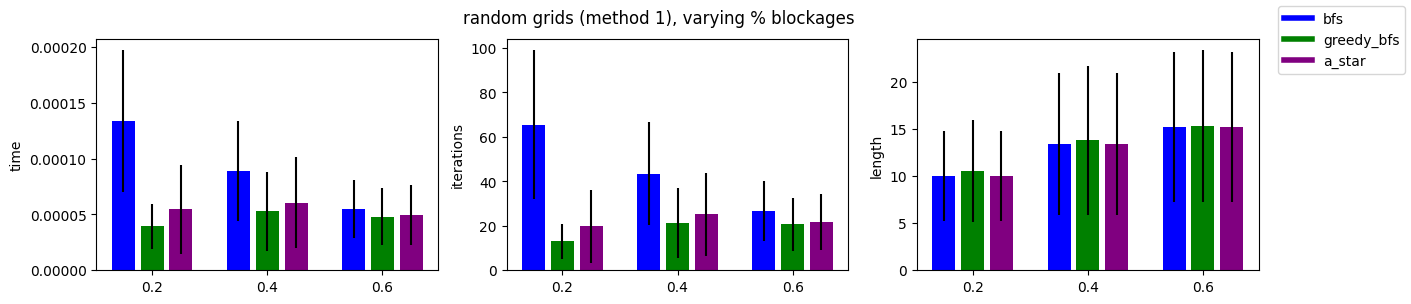

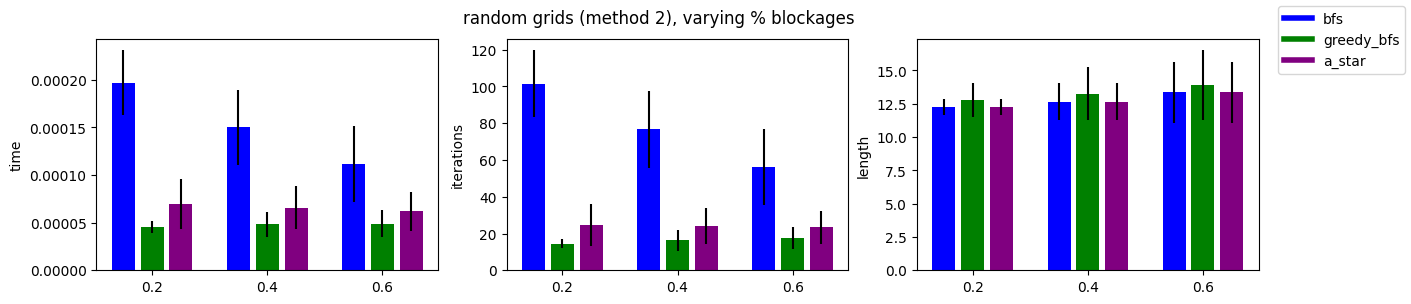

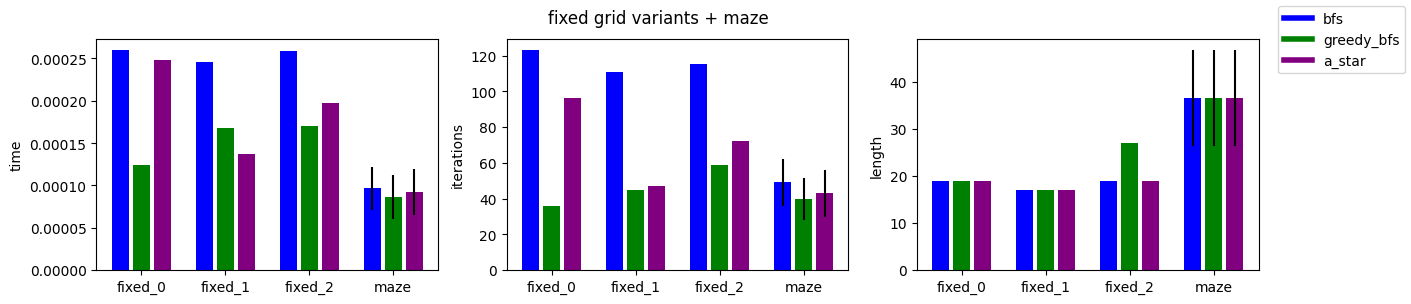

In [162]:
items_plot = list(map(lambda x : x["name"], to_search))

partition = list(filter(lambda x : x["type"] == "random", datas))
fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="percent", figsize=(15,3))
fig.suptitle("random grids (method 1), varying % blockages")
plt.show()

partition = list(filter(lambda x : x["type"] == "random-1", datas))
fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="percent", figsize=(15,3))
fig.suptitle("random grids (method 2), varying % blockages")
plt.show()

partition = list(filter(lambda x : x["type"].startswith("fixed") or x["type"] == "maze", datas))
fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="type", figsize=(15,3))
fig.suptitle("fixed grid variants + maze")
plt.show()

# Exhaustive Search

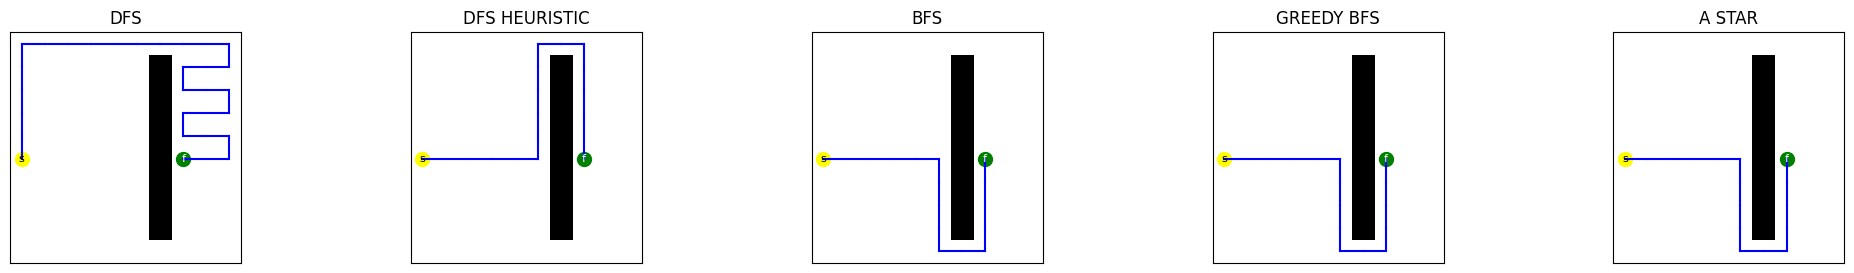

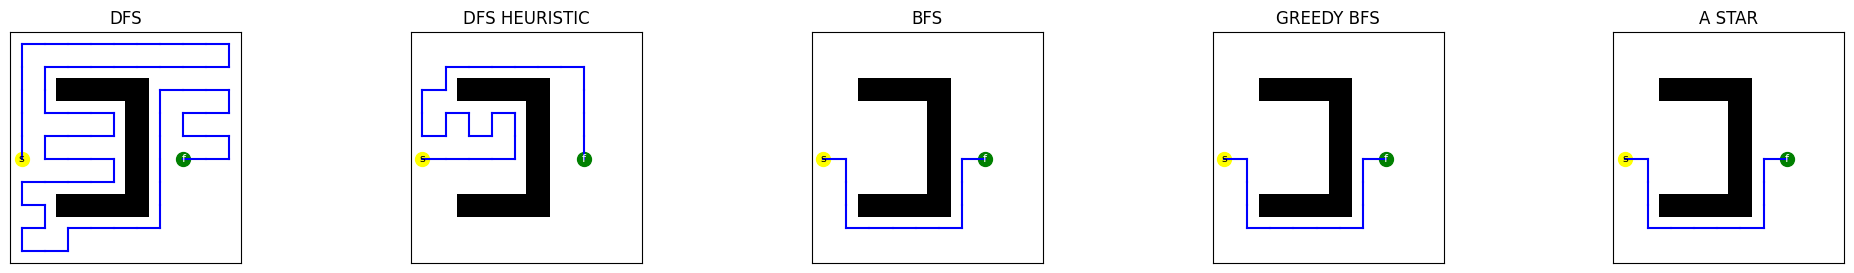

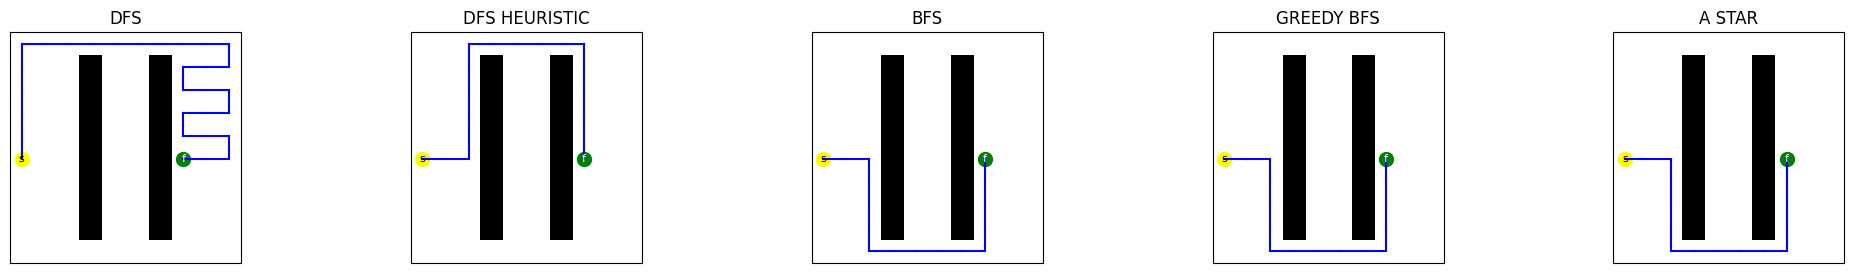

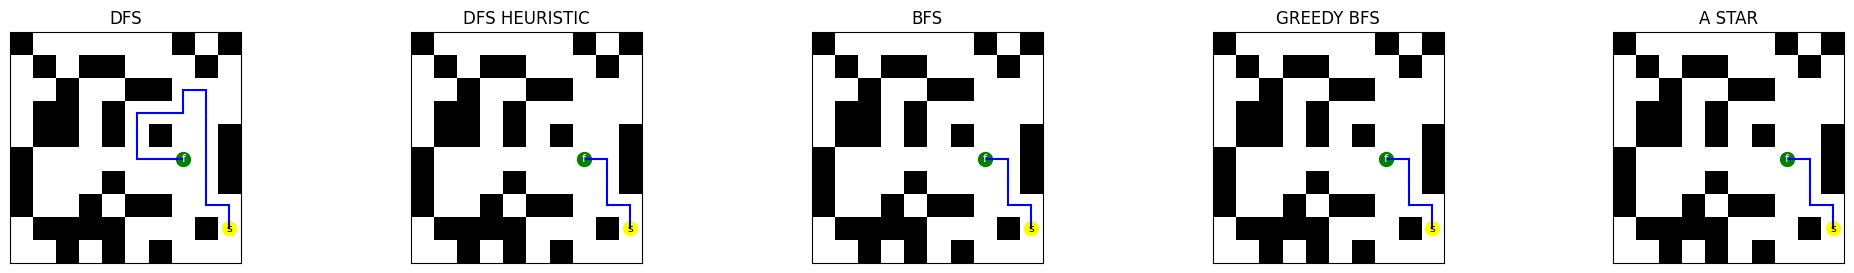

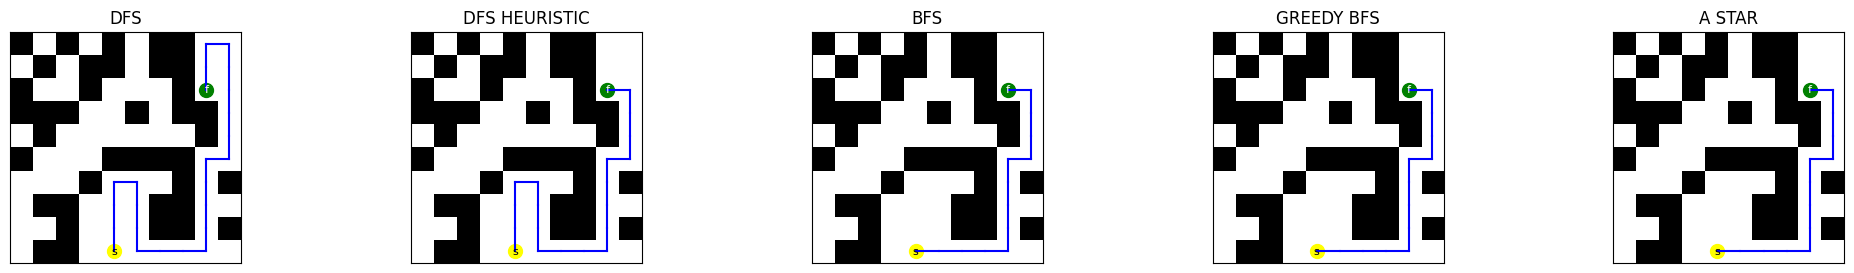

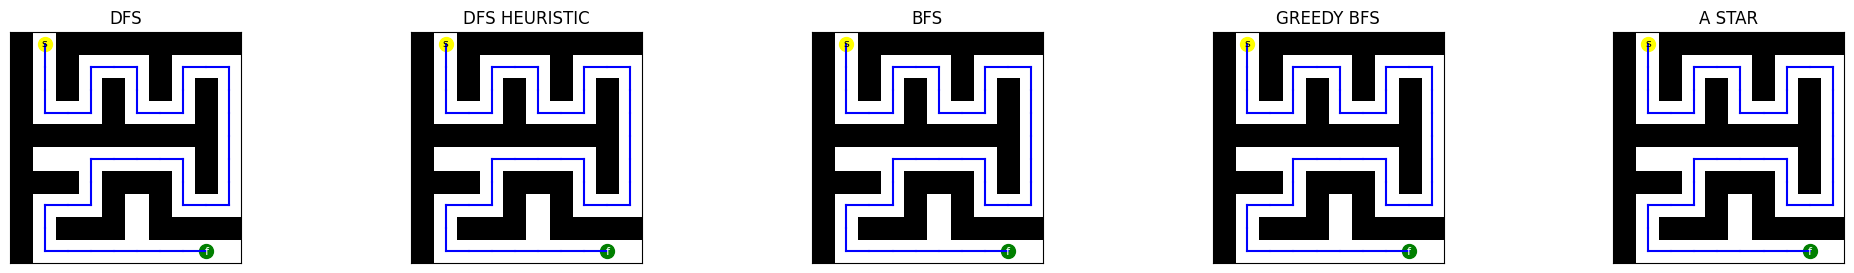

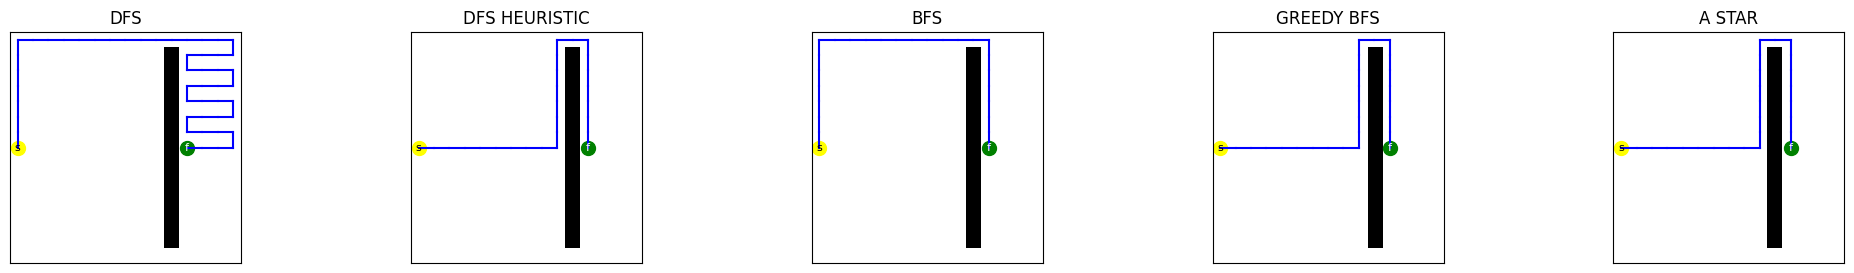

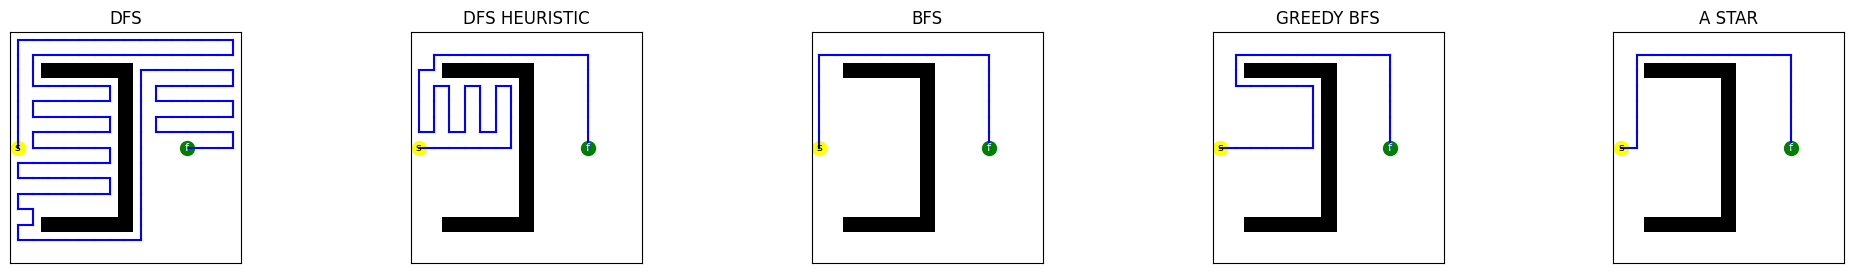

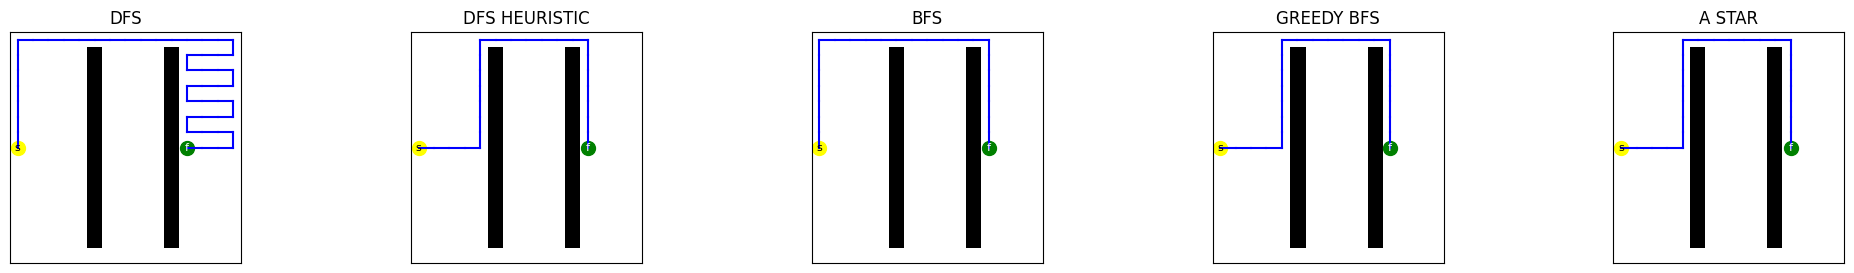

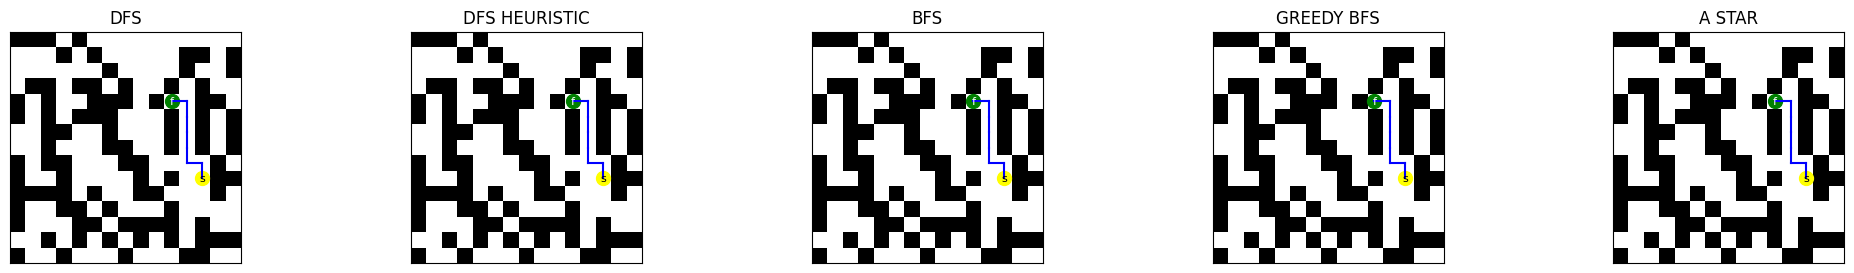

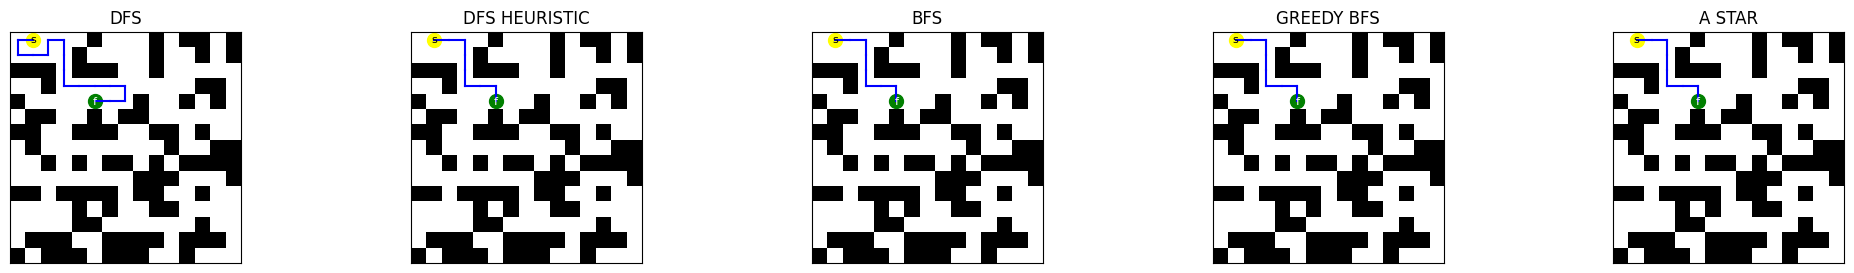

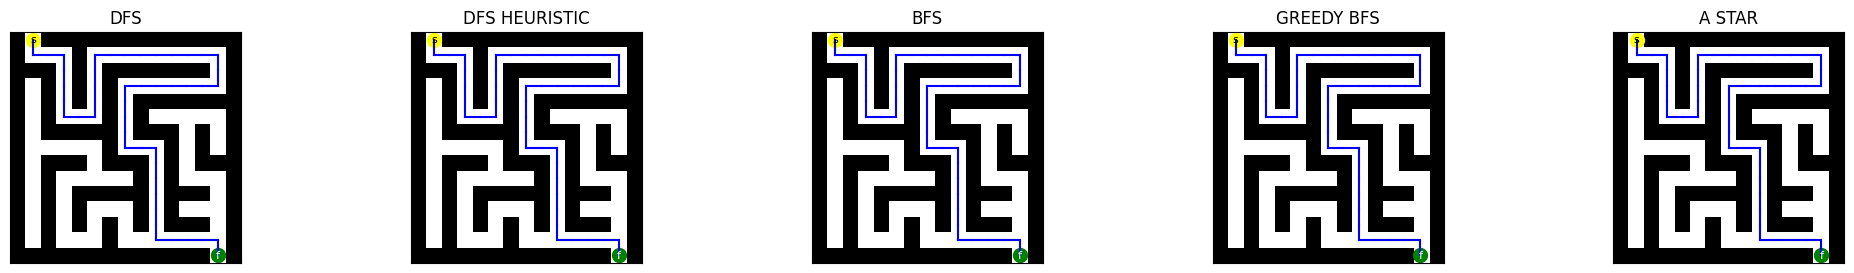

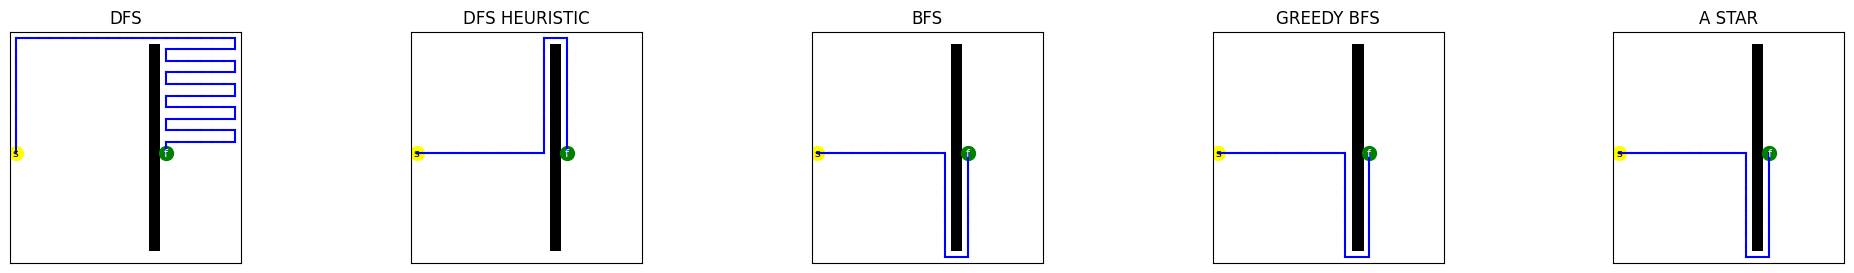

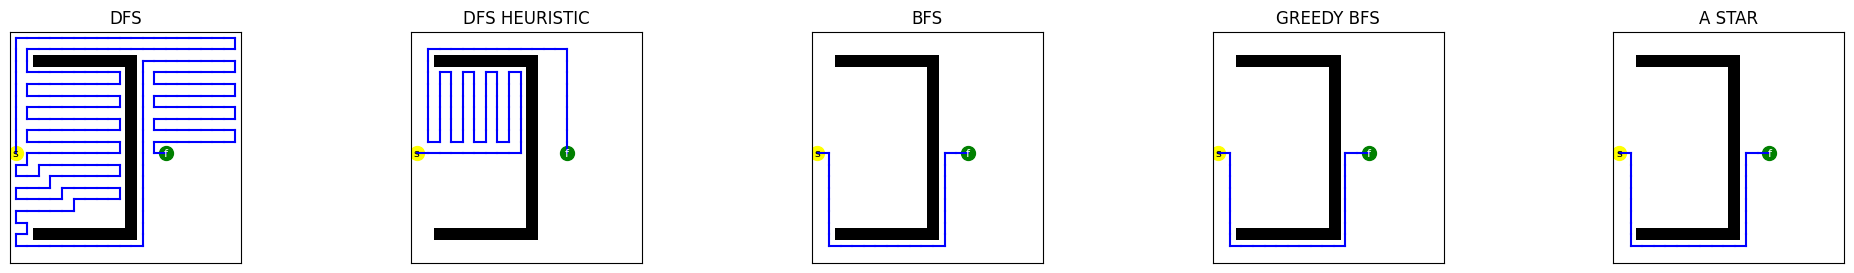

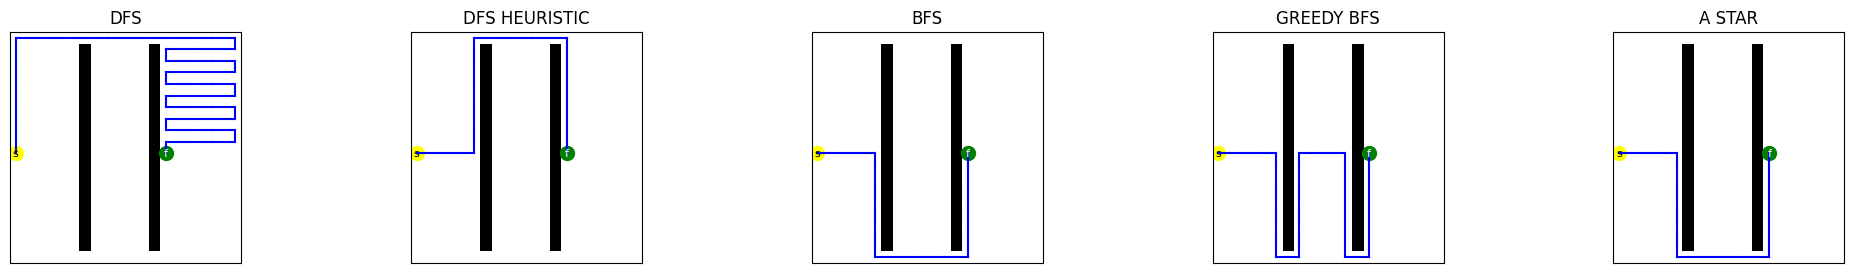

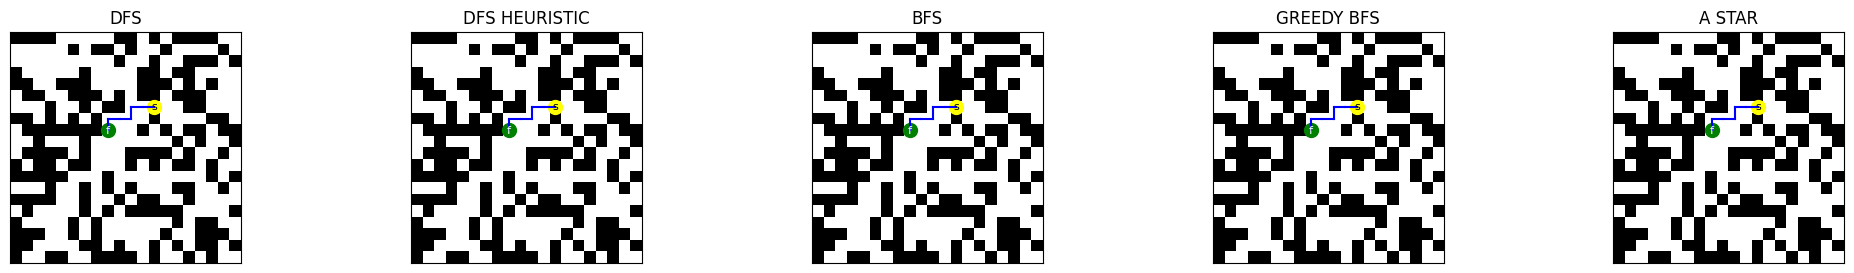

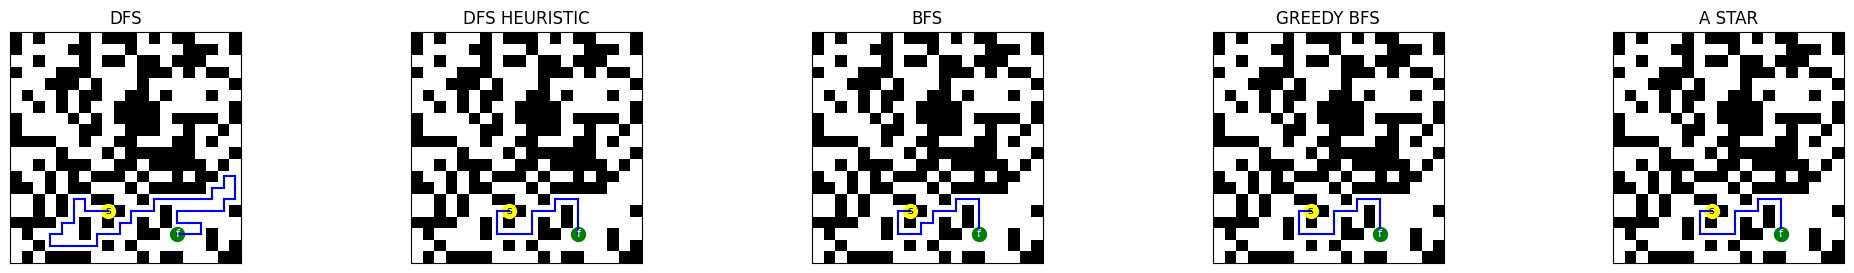

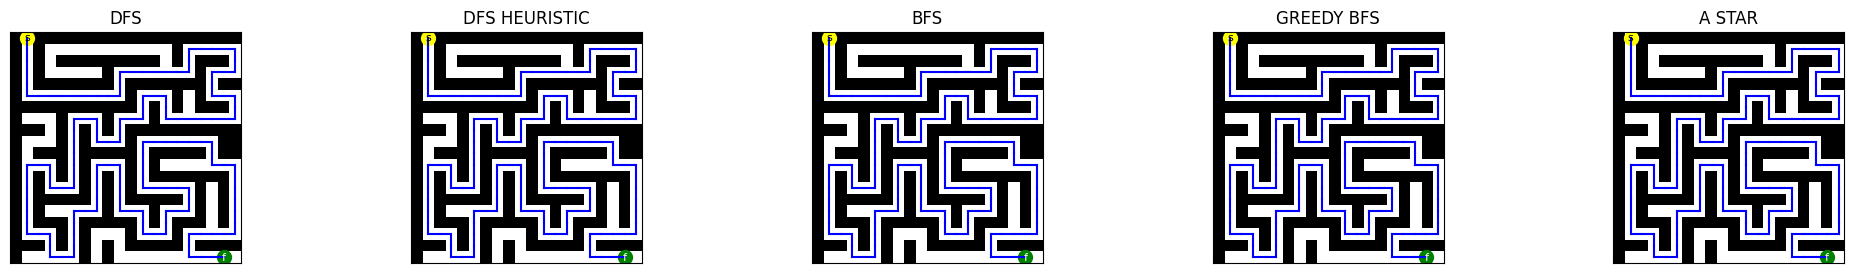

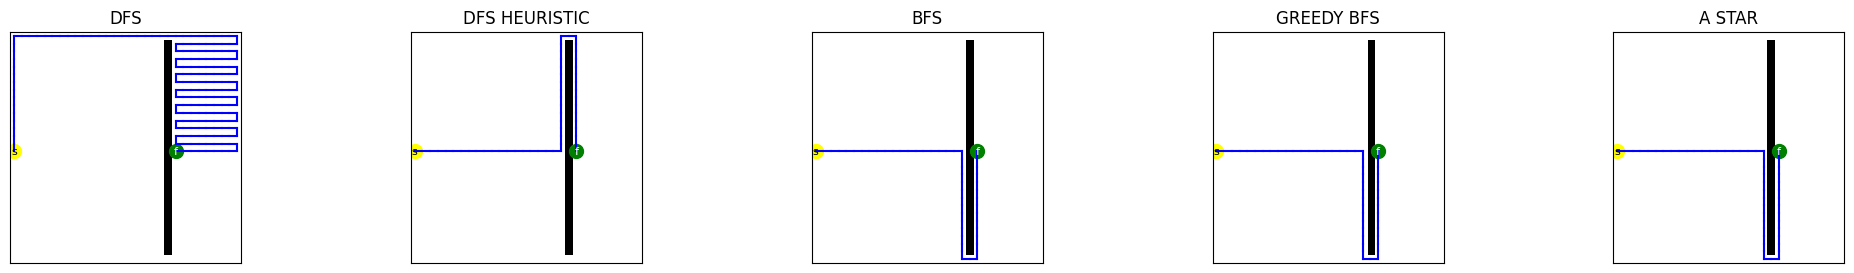

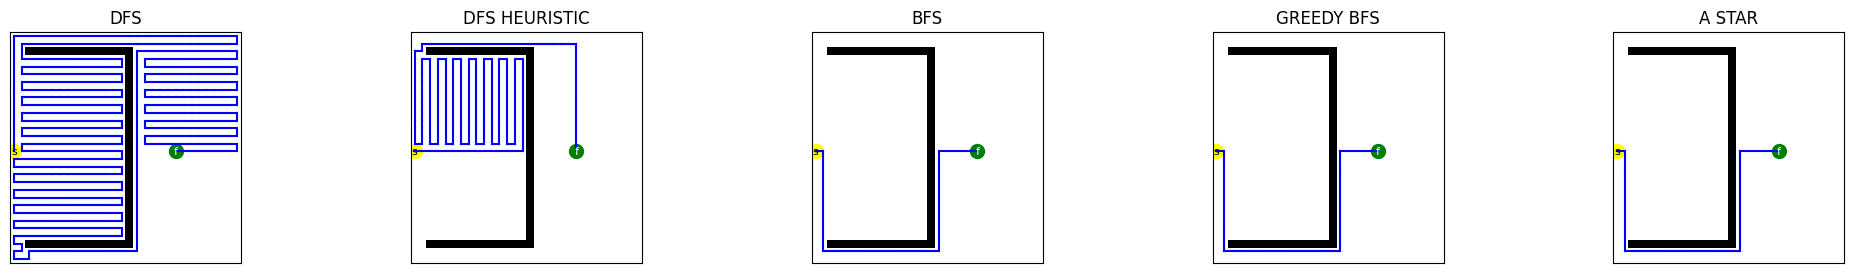

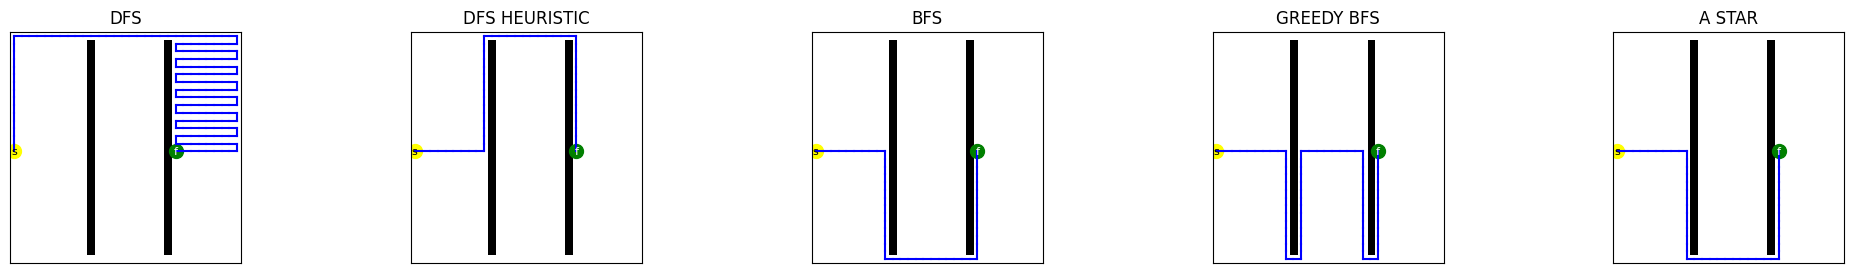

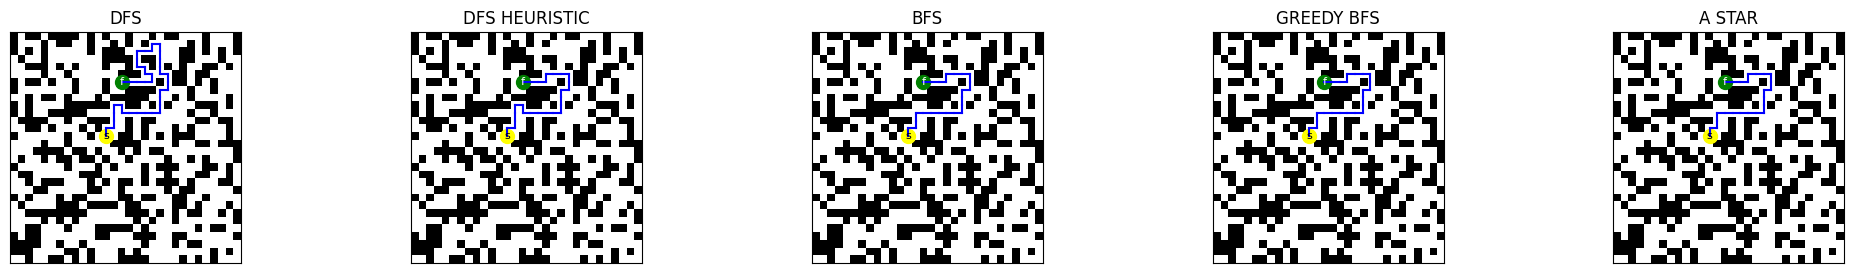

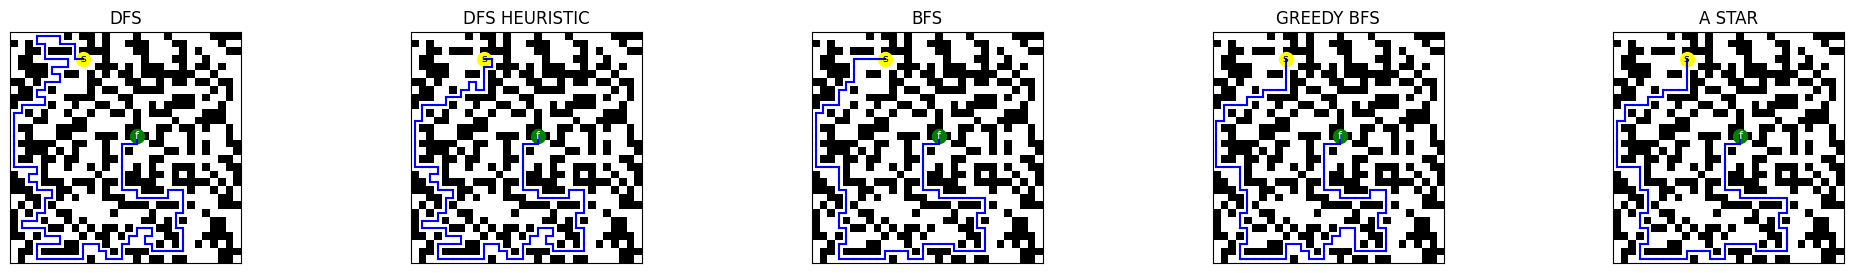

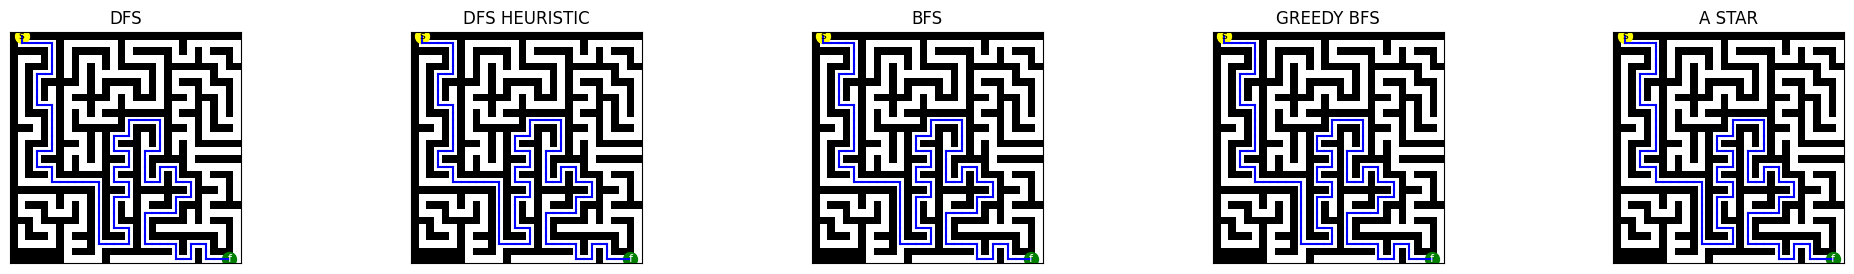

In [163]:
n = 500

datas = []

dimensions = [(10,10), (15,15), (20,20), (30,30)]
percent_blockages = [0.2, 0.4, 0.6]

to_search = [
    {
        "name": "dfs",
        "label": "DFS",
        "fct": dfs,
    },
    {
        "name": "dfs_heur",
        "label": "DFS HEURISTIC",
        "fct": dfs_heuristic,
    },
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "greedy_bfs",
        "label": "GREEDY BFS",
        "fct": greedy_bfs,
    },
    {
        "name": "a_star",
        "label": "A STAR",
        "fct": a_star,
    }
]

for (rows, cols) in dimensions:
    
    search = Search(rows=rows, cols=cols)

    for variant in [0,1,2]:
        data = {
            "percent": 0,
            "dimension": (rows, cols),
            "type": "fixed_" + str(variant),
        }
        search.generate_grid(grid_type="fixed", variant=variant)

        _, axes = plt.subplots(ncols=len(to_search), nrows=1, figsize=(len(to_search) * 5, 3))
        plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

        for i, searcher in enumerate(to_search):
            fct = searcher["fct"]
            name = searcher["name"]
            label = searcher["label"]
            path, complexity = search.search(searcher["fct"])

            data[name] = {"time": {}, "iterations": {}, "length": {}}

            data[name]["time"]["avg"] = complexity["time"]
            data[name]["iterations"]["avg"] = complexity["iterations"]
            data[name]["length"]["avg"] = complexity["length"]

            data[name]["time"]["std"] = 0
            data[name]["iterations"]["std"] = 0
            data[name]["length"]["std"] = 0

            plot_path(axes[i], path, c='blue',label=label)

        plt.show()

        datas.append(data)

    # Random grids with varying percent blockages
    for grid_type in ["random", "random-1"]:
        for percent in percent_blockages:
            data = {
                "percent": percent,
                "dimension": (rows, cols),
                "type": grid_type,
            }

            accumulator = {}
            for i in range(n):
                search.generate_grid(grid_type="random", percent_blocked=percent)

                if i == n - 1 and percent == 0.4:
                    _, axes = plt.subplots(ncols=len(to_search), nrows=1, figsize=(len(to_search) * 5, 3))
                    plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

                for j, searcher in enumerate(to_search):
                    fct = searcher["fct"]
                    name = searcher["name"]
                    label = searcher["label"]
                    path, complexity = search.search(searcher["fct"])

                    if name not in accumulator:
                        accumulator[name] = {"time": [], "iterations": [], "length": []}
                    
                    accumulator[name]["time"].append(complexity["time"])
                    accumulator[name]["iterations"].append(complexity["iterations"])
                    accumulator[name]["length"].append(complexity["length"])

                    if i == n - 1 and percent == 0.4:
                        plot_path(axes[j], path, c='blue',label=label)

            if percent == 0.4:
                plt.show()
            
            for name, keys in accumulator.items():
                data[name] = {}
                for key, values in keys.items():
                    data[name][key] = {"avg": mean(values), "std": stdev(values)}
            datas.append(data)
    # Maze grids
    data = {
        "percent": 0,
        "dimension": (rows, cols),
        "type": "maze",
    }

    accumulator = {}
    for i in range(n):
        search.generate_grid(grid_type="maze")

        if i == n - 1:
            _, axes = plt.subplots(ncols=len(to_search), nrows=1, figsize=(len(to_search) * 5, 3))
            plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

        for j, searcher in enumerate(to_search):
            fct = searcher["fct"]
            name = searcher["name"]
            label = searcher["label"]
            path, complexity = search.search(searcher["fct"])

            if complexity["time"] is None: continue

            if name not in accumulator:
                accumulator[name] = {"time": [], "iterations": [], "length": []}
            
            accumulator[name]["time"].append(complexity["time"])
            accumulator[name]["iterations"].append(complexity["iterations"])
            accumulator[name]["length"].append(complexity["length"])

            if i == n - 1:
                plot_path(axes[j], path, c='blue',label=label)
    
    plt.show()

    for name, keys in accumulator.items():
        data[name] = {}
        for key, values in keys.items():
            data[name][key] = {"avg": mean(values), "std": stdev(values)}
    datas.append(data)




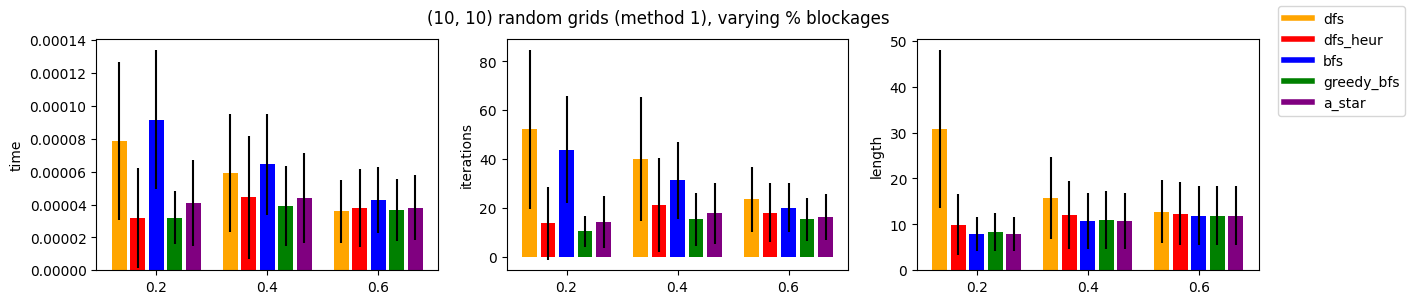

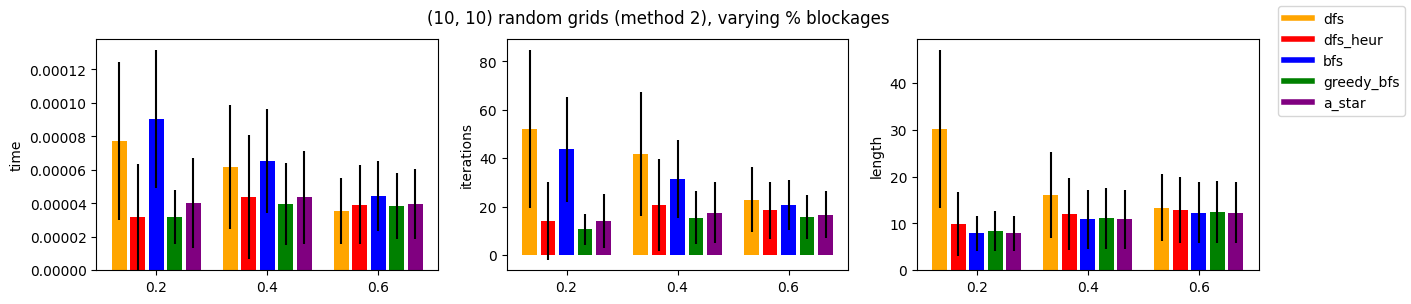

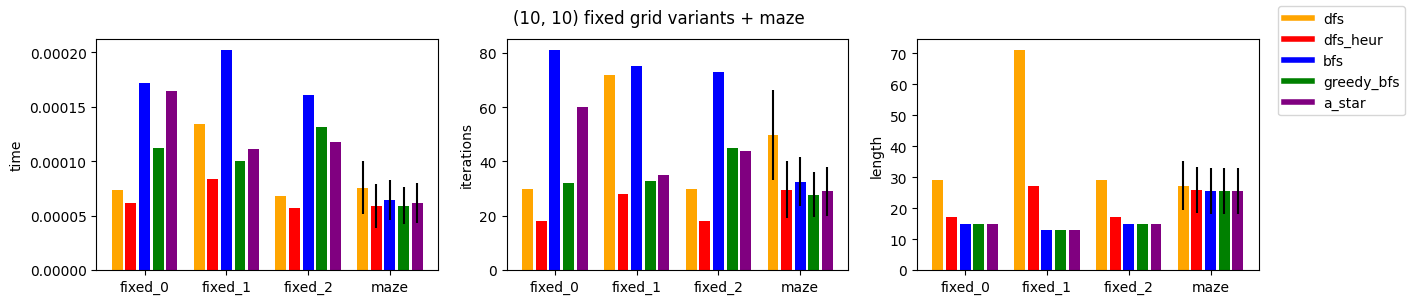

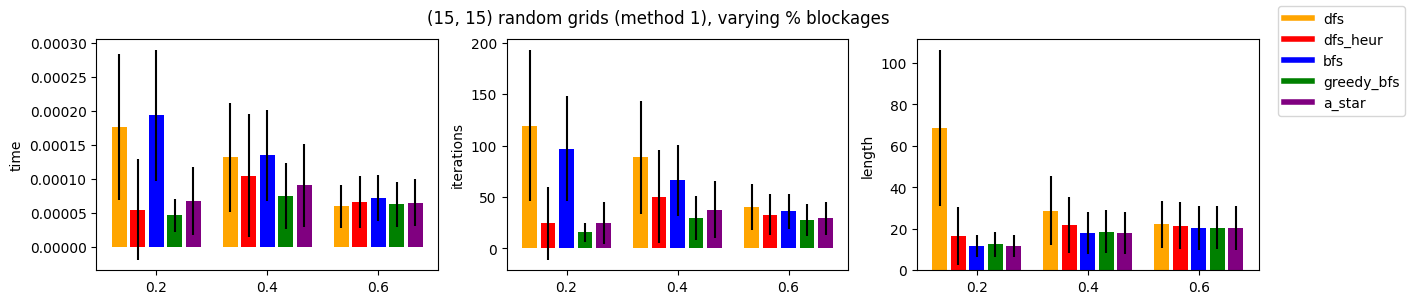

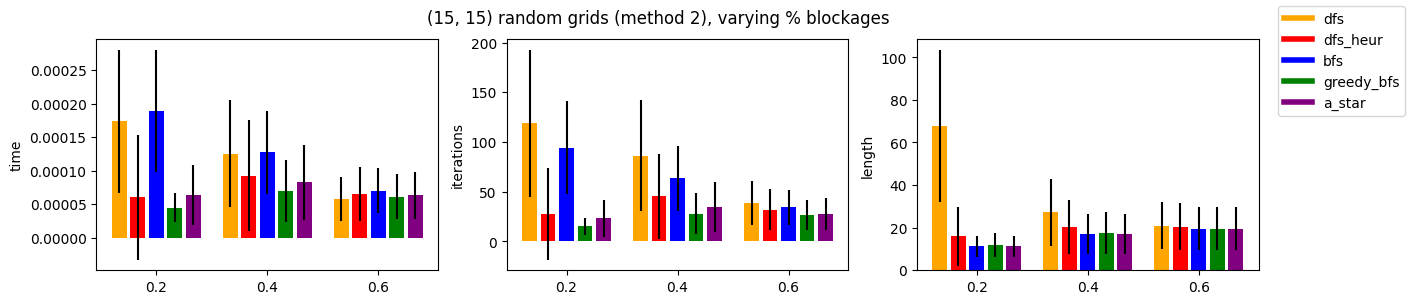

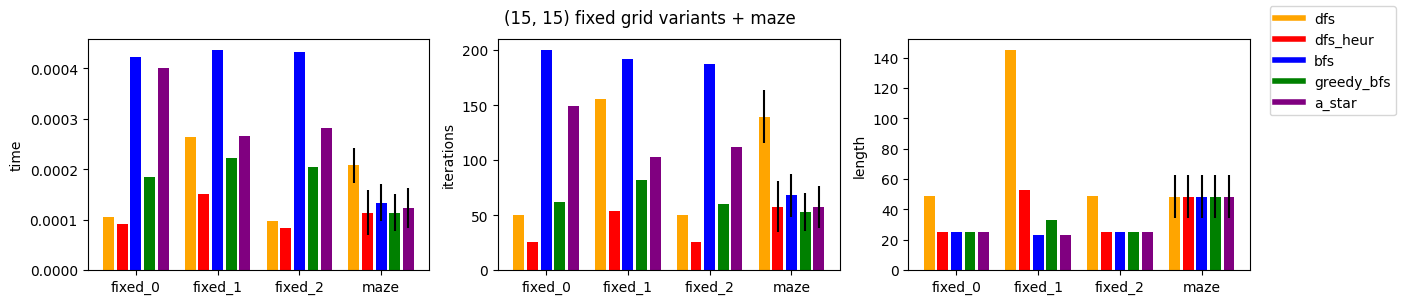

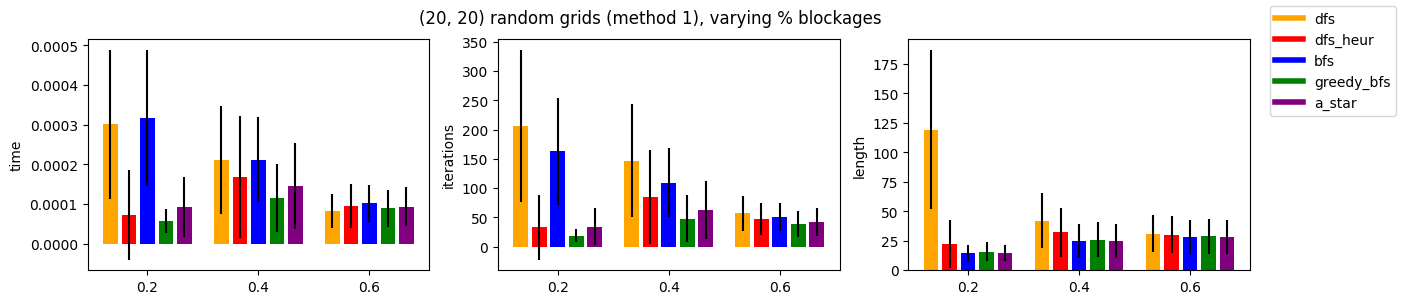

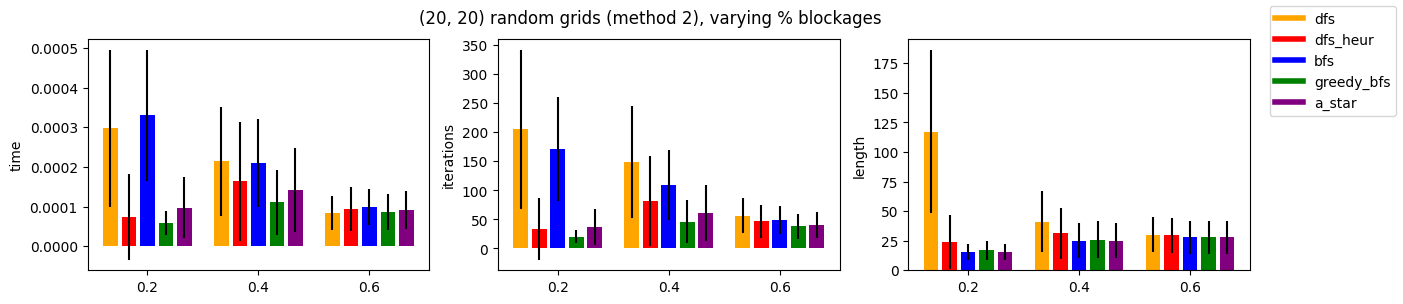

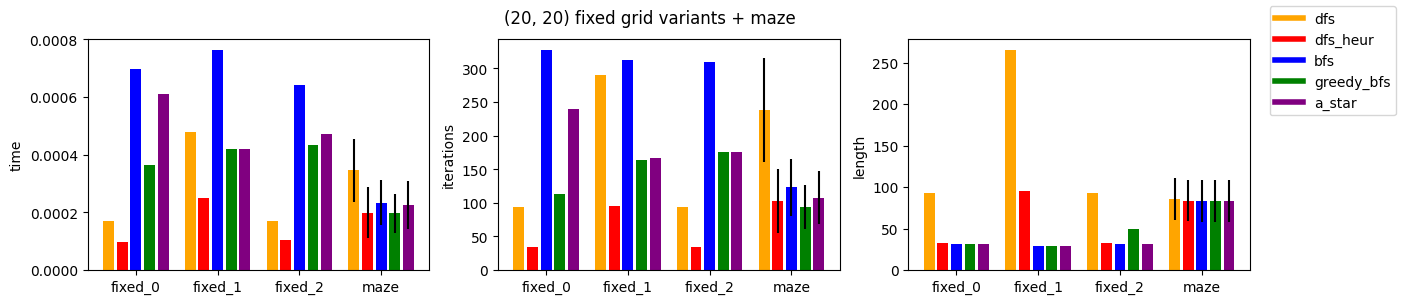

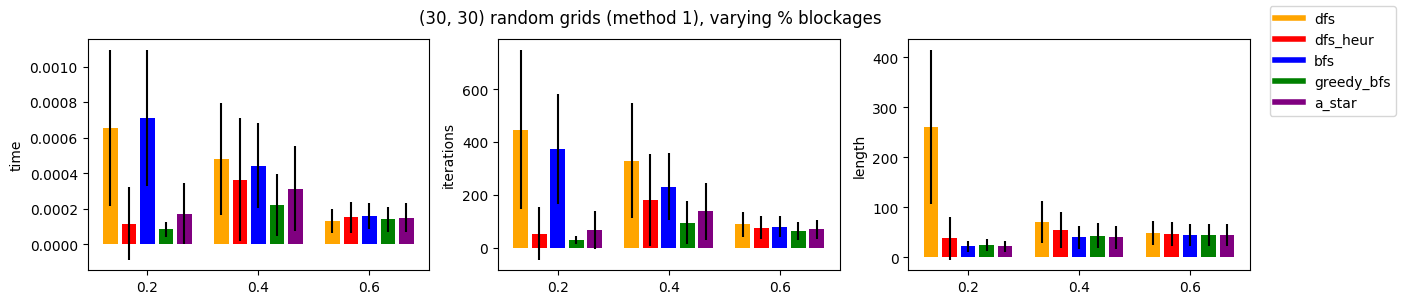

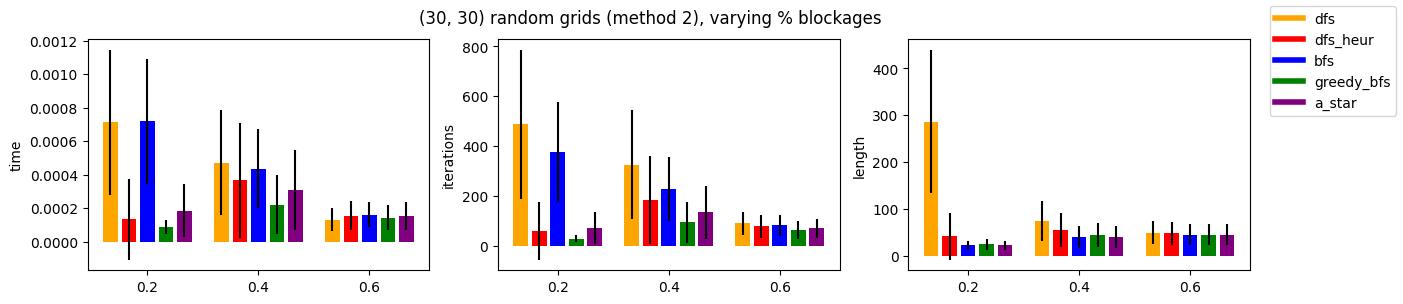

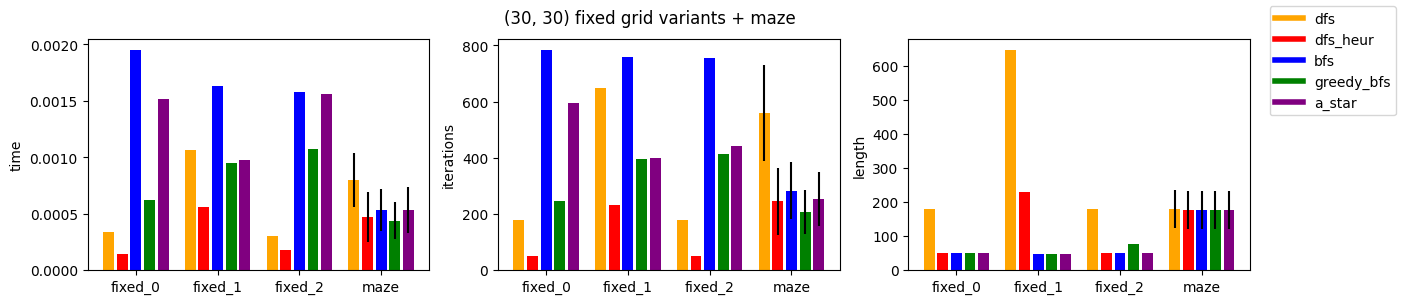

In [165]:
items_plot = list(map(lambda x : x["name"], to_search))

for dim in [(10,10), (15,15), (20,20), (30,30)]:

    partition = list(filter(lambda x : x["type"] == "random" and x["dimension"] == dim, datas))
    fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="percent", figsize=(15,3))
    fig.suptitle(f"{dim} random grids (method 1), varying % blockages")
    plt.show()

    partition = list(filter(lambda x : x["type"] == "random-1" and x["dimension"] == dim, datas))
    fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="percent", figsize=(15,3))
    fig.suptitle(f"{dim} random grids (method 2), varying % blockages")
    plt.show()

    partition = list(filter(lambda x : (x["type"].startswith("fixed") or x["type"] == "maze") and x["dimension"] == dim, datas))
    fig = bar_chart_performance(partition, colormap=colormap, items=items_plot, key="type", figsize=(15,3))
    fig.suptitle(f"{dim} fixed grid variants + maze")
    plt.show()


## Let's see these in action on the fixed grid variants

First we'll start with orthogonal movement, manhattan distance heuristic

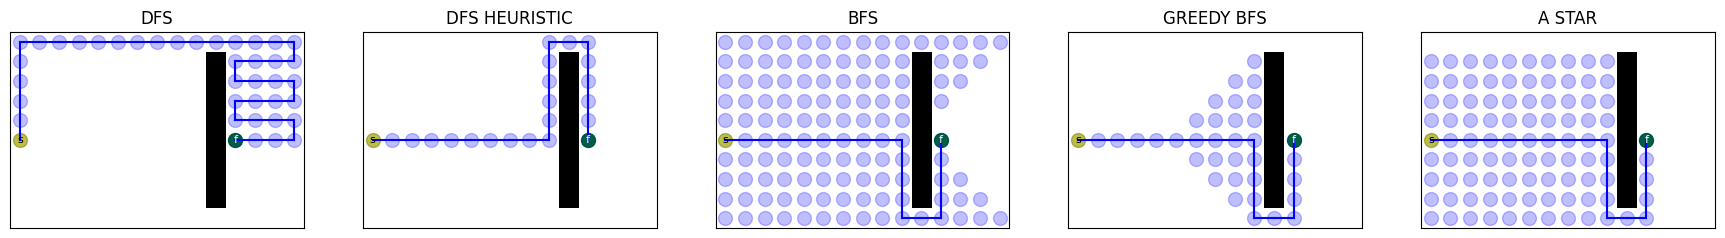

In [166]:
search = Search(rows=10, cols=15)

search.generate_grid(grid_type="fixed", variant=0)

dfs_generator = search.search_generator(dfs)
dfs_heur_generator = search.search_generator(dfs_heuristic)
bfs_generator = search.search_generator(bfs)
greedy_bfs_generator = search.search_generator(greedy_bfs)
astar_generator = search.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

# print("ORDER (fast to slow):")
# print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

Then we'll look at diagonal movement, euclidean distance

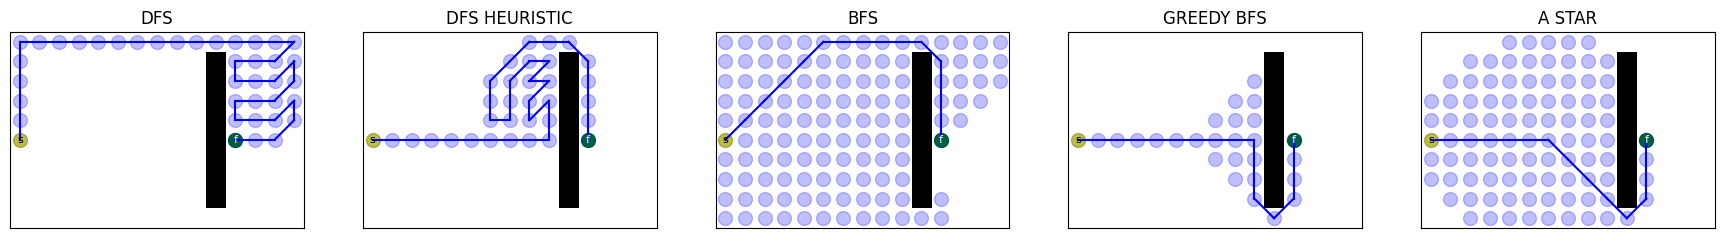

In [169]:
search = Search(rows=10, cols=15)

search.generate_grid(grid_type="fixed", variant=0, allow_diagonal=True)

dfs_generator = search.search_generator(dfs, method="euclidean")
dfs_heur_generator = search.search_generator(dfs_heuristic, method="euclidean")
bfs_generator = search.search_generator(bfs, method="euclidean")
greedy_bfs_generator = search.search_generator(greedy_bfs, method="euclidean")
astar_generator = search.search_generator(a_star, method="euclidean")

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

# print("ORDER (fast to slow):")
# print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

Then diagonal movement, chebyshev heuristic

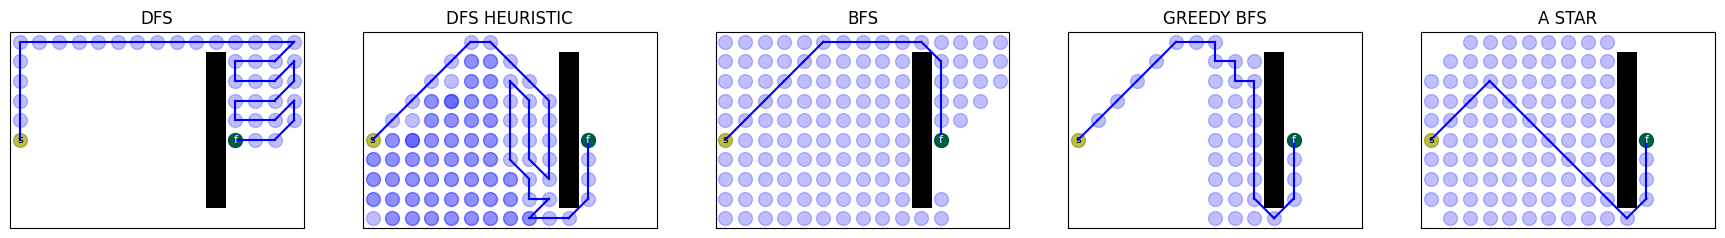

In [170]:
search = Search(rows=10, cols=15)

search.generate_grid(grid_type="fixed", variant=0, allow_diagonal=True)

dfs_generator = search.search_generator(dfs, method="chebyshev")
dfs_heur_generator = search.search_generator(dfs_heuristic, method="chebyshev")
bfs_generator = search.search_generator(bfs, method="chebyshev")
greedy_bfs_generator = search.search_generator(greedy_bfs, method="chebyshev")
astar_generator = search.search_generator(a_star, method="chebyshev")

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

# print("ORDER (fast to slow):")
# print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

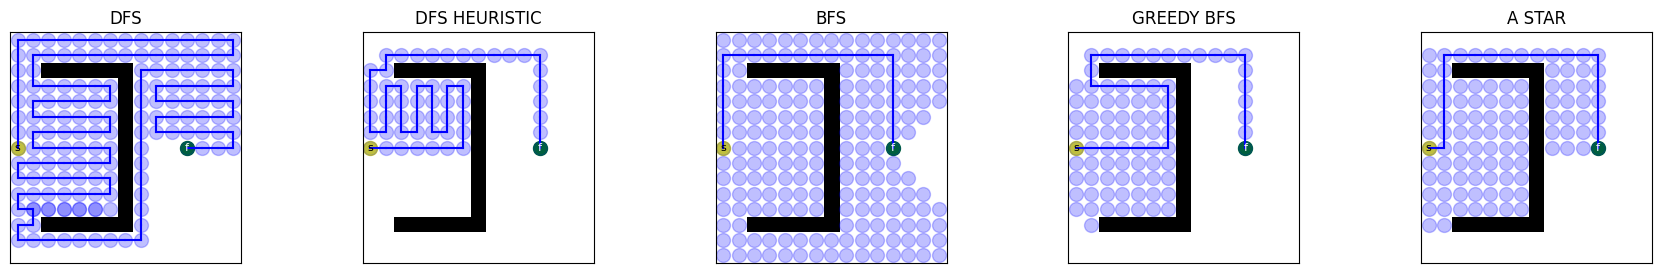

In [534]:
search = Search(rows=15, cols=15)

search.generate_grid(grid_type="fixed", variant=1)

dfs_generator = search.search_generator(dfs)
dfs_heur_generator = search.search_generator(dfs_heuristic)
bfs_generator = search.search_generator(bfs)
greedy_bfs_generator = search.search_generator(greedy_bfs)
astar_generator = search.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

# print("ORDER (fast to slow):")
# print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

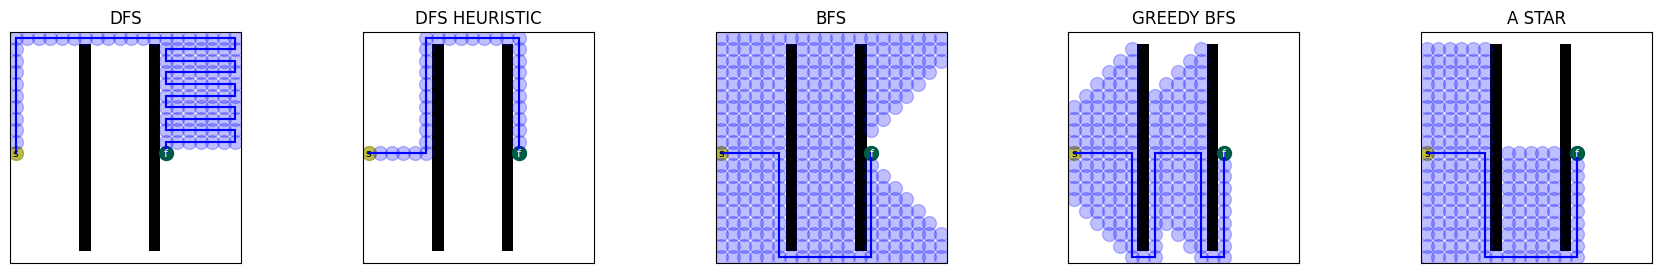

In [541]:
search = Search(rows=20, cols=20)

search.generate_grid(grid_type="fixed", variant=2)

dfs_generator = search.search_generator(dfs)
dfs_heur_generator = search.search_generator(dfs_heuristic)
bfs_generator = search.search_generator(bfs)
greedy_bfs_generator = search.search_generator(greedy_bfs)
astar_generator = search.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(search.p_start, search.p_end, search.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

# print("ORDER (fast to slow):")
# print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

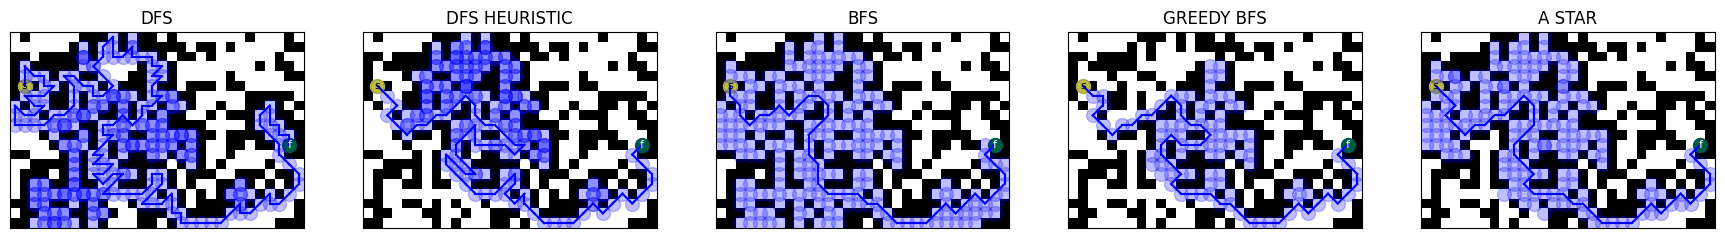

In [173]:
search = Search(rows=20, cols=30)

search.generate_grid(grid_type="random", percent_blocked=0.4, allow_diagonal=True)

dfs_generator = search.search_generator(dfs)
dfs_heur_generator = search.search_generator(dfs_heuristic)
bfs_generator = search.search_generator(bfs)
greedy_bfs_generator = search.search_generator(greedy_bfs)
astar_generator = search.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,6))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

# print("ORDER (fast to slow):")
# print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

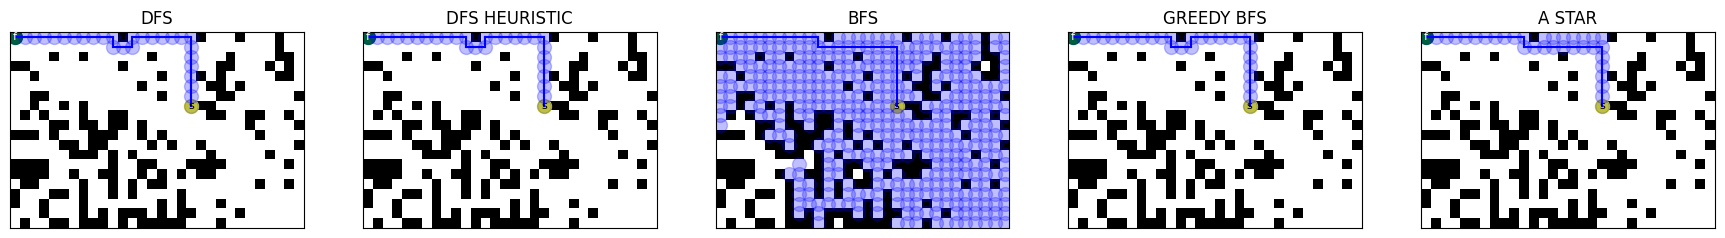

In [174]:
search = Search(rows=20, cols=30)

search.generate_grid(grid_type="random-1", percent_blocked=0.4)

dfs_generator = search.search_generator(dfs)
dfs_heur_generator = search.search_generator(dfs_heuristic)
bfs_generator = search.search_generator(bfs)
greedy_bfs_generator = search.search_generator(greedy_bfs)
astar_generator = search.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

# print("ORDER (fast to slow):")
# print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

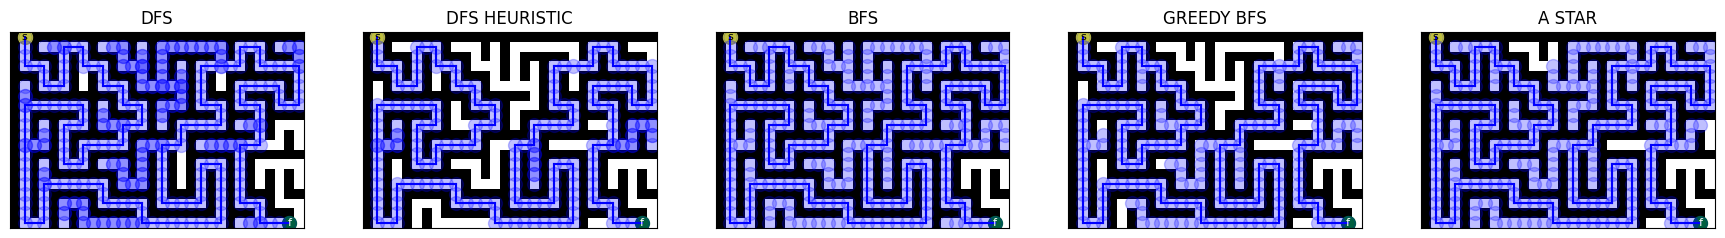

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
a_star
bfs
dfs


In [175]:
search = Search(rows=20, cols=30)

search.generate_grid(grid_type="maze")

dfs_generator = search.search_generator(dfs)
dfs_heur_generator = search.search_generator(dfs_heuristic)
bfs_generator = search.search_generator(bfs)
greedy_bfs_generator = search.search_generator(greedy_bfs)
astar_generator = search.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

### Exploring Jump Point Search

This isn't really a 1-to-1 comparison since JPS does recursion within each loop iteration. I emit another event called "search" that we can look into.

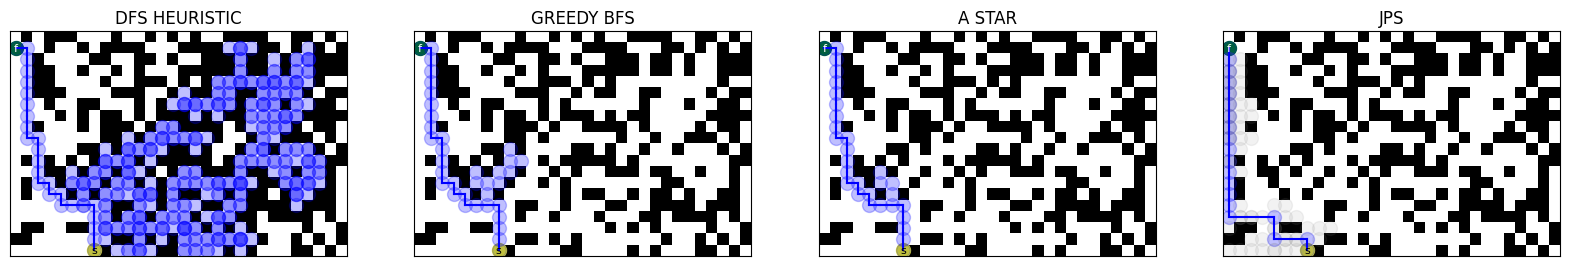

ORDER (fast to slow):
a_star
greedy_bfs
jps
dfs_heuristic


In [177]:
search = Search(rows=20, cols=30)

search.generate_grid(grid_type="random-1", percent_blocked=0.4)
# search.generate_grid(grid_type="maze")

dfs_heur_generator = search.search_generator(dfs_heuristic)
greedy_bfs_generator = search.search_generator(greedy_bfs)
astar_generator = search.search_generator(a_star)
jps_generator = search.search_generator(jps)

generators = [dfs_heur_generator, greedy_bfs_generator, astar_generator, jps_generator]

_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
plot_grid(search.p_start, search.p_end, search.grid.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
scans = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
x_coords_scan = [[] for _ in range(5)]
y_coords_scan = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scan = axes[i].scatter(x_coords_scan[i], y_coords_scan[i], s=100, c="gray", alpha=.1)
    scatters.append(scatter)
    scans.append(scan)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "scan":
            x_coords_scan[i].append(node[1])
            y_coords_scan[i].append(node[0])
            # Update data of scatter plot
            scans[i].set_offsets(list(zip(x_coords_scan[i], y_coords_scan[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS HEURISTIC")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("A STAR")
    axes[3].set_title("JPS")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()